In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/CosmiQ/simrdwn

Cloning into 'simrdwn'...
remote: Enumerating objects: 840, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 840 (delta 0), reused 0 (delta 0), pack-reused 839
Receiving objects: 100% (840/840), 138.52 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (479/479), done.


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
import shutil

In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/sample_submission_v2.csv','/content/')
shutil.copy('/content/drive/MyDrive/train_ship_segmentations_v2.csv.zip','/content/')
shutil.copy('/content/drive/MyDrive/train_v2(5).zip','/content/')

'/content/train_v2(5).zip'

In [ ]:
import zipfile
with zipfile.ZipFile('/content/train_v2(5).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train')

In [ ]:
ships = pd.read_csv("/content/drive/MyDrive/train_ship_segmentations_v2.csv.zip (Unzipped Files)/train_ship_segmentations_v2.csv")
test_data = pd.read_csv("/content/drive/MyDrive/sample_submission_v2.csv")

In [ ]:
ships["Ship"] = ships["EncodedPixels"].map(lambda x:1 if isinstance(x,str) else 0)
ship_unique = ships[["ImageId","Ship"]].groupby("ImageId").agg({"Ship":"sum"}).reset_index()

In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Transform data from:
    https://gdo152.llnl.gov/cowc/
"""

from __future__ import print_function
import shapely.geometry
import pandas as pd
import numpy as np
import argparse
import shapely
import shutil
import pickle
import time
import cv2
import os
# import sys
# path_simrdwn_core = os.path.dirname(os.path.realpath(__file__))
# sys.path.append(path_simrdwn_core)
import yolt_data_prep_funcs

###############################################################################
def gt_boxes_from_cowc_png(gt_c, yolt_box_size, verbose=False):
    '''
    Get ground truth locations from cowc ground_truth image
    input:
        gt_c is cowc label image
        yolt_box_size is the size of each car in pixels
    outputs:
        box_coords = [x0, x1, y0, y1]
        yolt_coords = convert.conver(box_coords)
    '''

    win_h, win_w = gt_c.shape[:2]

    # find locations of labels (locs => (h, w))
    label_locs = list(zip(*np.where(gt_c > 0)))
    # label_locs = zip(*np.where(gt_c > 0))
    # print ("label_locs:", label_locs)

    # skip if label_locs is empty
    if len(label_locs) == 0:
        if verbose:
            print("Label empty")
        return [], []

    if verbose:
        print("Num cars:", len(label_locs))

    # else, create yolt labels from car locations
    # make boxes around cars
    box_coords = []
    yolt_coords = []
    grid_half = yolt_box_size/2
    for i, l in enumerate(label_locs):

        if verbose and (i % 100) == 0:
            print(i, "/", len(label_locs))

        ymid, xmid = l
        x0, y0, x1, y1 = xmid - grid_half, ymid - grid_half, \
            xmid + grid_half, ymid + grid_half
        x0 = max(0, x0)
        y0 = max(0, y0)
        x1 = min(x1, gt_c.shape[1]-1)
        y1 = min(y1, gt_c.shape[0]-1)
        box_i = [x0, x1, y0, y1]
        box_coords.append(box_i)
        # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
        yolt_co_i = yolt_data_prep_funcs.convert((win_w, win_h), box_i)
        yolt_coords.append(yolt_co_i)

    box_coords = np.array(box_coords)
    yolt_coords = np.array(yolt_coords)

    return box_coords, yolt_coords


###############################################################################
def cowc_box_coords_to_gdf(box_coords, image_path, category, verbose=False):
    '''Convert box_coords to geodataframe, assume schema:
        box_coords = [x0, x1, y0, y1]
        Adapted from parse_shapefile.py'''

    pix_geom_poly_list = []
    for i, b in enumerate(box_coords):
        if verbose and ((i % 100) == 0):
            print("  ", i, "box:", b)
        [x0, x1, y0, y1] = b
        out_coords = [[x0, y0], [x0, y1], [x1, y1], [x1, y0]]
        points = [shapely.geometry.Point(coord) for coord in out_coords]
        pix_poly = shapely.geometry.Polygon([[p.x, p.y] for p in points])
        pix_geom_poly_list.append(pix_poly)

    df_shp = pd.DataFrame(pix_geom_poly_list, columns=['geometry_poly_pixel'])

    # df_shp['geometry_poly_pixel'] = pix_geom_poly_list
    df_shp['geometry_pixel'] = pix_geom_poly_list
    df_shp['geometry_poly_pixel'] = pix_geom_poly_list
    df_shp['xmin'] = box_coords[:, 0]
    df_shp['xmax'] = box_coords[:, 1]
    df_shp['ymin'] = box_coords[:, 2]
    df_shp['ymax'] = box_coords[:, 3]
    df_shp['shp_file'] = ''
    df_shp['Category'] = category
    df_shp['Image_Path'] = image_path
    df_shp['Image_Root'] = image_path.split('/')[-1]

    df_shp.index = np.arange(len(df_shp))

    return df_shp


###############################################################################
def cowc_to_gdf(label_image_path, image_path,
                category, yolt_box_size, rescale_to_int=True, verbose=False):
    '''yolt_box_size is size of car in pixels
    rescale ground truth box locations to correct image size if raw image is
    a different shape than the label image'''

    gt_c = cv2.imread(label_image_path, 0)
    box_coords_init, yolt_coords = gt_boxes_from_cowc_png(gt_c, yolt_box_size,
                                                          verbose=verbose)
    # rescale yolt_coords to dimensions of input image
    im = cv2.imread(image_path, 0)
    h, w = im.shape[:2]
    print("gt_c.shape:", gt_c.shape)
    print("im.shape:", im.shape)

    if im.shape != gt_c.shape:
        boxes_rescale = []
        for yb in yolt_coords:
            box_tmp_init = yolt_data_prep_funcs.convert_reverse((w, h), yb)
            # rescale to ints
            if rescale_to_int:
                box_tmp = [np.rint(itmp) for itmp in box_tmp_init]
            else:
                box_tmp = box_tmp_init
            boxes_rescale.append(box_tmp)

        box_coords = np.asarray(boxes_rescale)

    else:
        box_coords = box_coords_init

    df = cowc_box_coords_to_gdf(box_coords, image_path, category,
                                verbose=verbose)

    return df


###############################################################################
def get_gdf_tot_cowc(truth_dir, image_dir='',
                     annotation_suffix='_Annotated_Cars.png',
                     category='car', yolt_box_size=10, outfile_df='',
                     verbose=False):
    '''
    yolt_box_size is car size in pixels
    '''

    print("Executing get_gdf_tot_cowc()...")

    gt_files = [f for f in os.listdir(
        truth_dir) if f.endswith(annotation_suffix)]
    for i, gt_file in enumerate(gt_files):
        basename_annotated = os.path.basename(gt_file)
        basename = basename_annotated.split(annotation_suffix)[0] + '.png'
        label_image_path = os.path.join(truth_dir, basename_annotated)

        # if image_dir is provided
        if len(image_dir) > 0:
            image_path = os.path.join(image_dir, basename)
        else:
            image_path = os.path.jin(truth_dir, basename)
        print(i, "label_image_path:", label_image_path)
        print(i, "image_path:", image_path)

        gdf = cowc_to_gdf(label_image_path, image_path, category,
                          yolt_box_size, verbose=verbose)

        if verbose:
            print("gdf.columns:", gdf.columns)
        # check that pixel coords are > 0
        if np.min(gdf['xmin'].values) < 0:
            if verbose:
                print("x pixel coords < 0:", np.min(gdf['xmin'].values))

        if np.min(gdf['ymin'].values) < 0:
            if verbose:
                print("y pixel coords < 0:", np.min(gdf['ymin'].values))

        if i == 0:
            gdf_tot = gdf
        else:
            gdf_tot = gdf_tot.append(gdf)
    gdf_tot.index = np.arange(len(gdf_tot))

    if len(outfile_df) > 0:
        gdf_tot.to_csv(outfile_df)

    return gdf_tot


###############################################################################
def gt_dic_from_box_coords(box_coords):
    '''
    box_coords are of form:
        box_coords = [x0, x1, y0, y1]
    output should be of form:
    x1l0, y1l0 = lineData['pt1X'].astype(int), lineData['pt1Y'].astype(int)
    x2l0, y2l0 = lineData['pt2X'].astype(int), lineData['pt2Y'].astype(int)
    x3l0, y3l0 = lineData['pt3X'].astype(int), lineData['pt3Y'].astype(int)
    x4l0, y4l0 = lineData['pt4X'].astype(int), lineData['pt4Y'].astype(int)
    assume pt1 is stern, pt2 is bow, pt3 and pt4 give width

    '''

    box_coords = np.array(box_coords)
    out_dic = {}

    out_dic['pt1X'] = box_coords[:, 0]
    out_dic['pt1Y'] = box_coords[:, 2]

    # set p2 as diagonal from p1
    out_dic['pt2X'] = box_coords[:, 1]  # box_coords[:,1]
    out_dic['pt2Y'] = box_coords[:, 3]  # box_coords[:,2]

    out_dic['pt3X'] = box_coords[:, 1]  # box_coords[:,1]
    out_dic['pt3Y'] = box_coords[:, 2]  # box_coords[:,3]

    out_dic['pt4X'] = box_coords[:, 0]
    out_dic['pt4Y'] = box_coords[:, 3]

    return out_dic


###############################################################################
def slice_im_cowc(input_im, input_mask, outname_root, outdir_im, outdir_label,
                  classes_dic, category, yolt_box_size,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0.2, overlap=0.2, pad=0, verbose=False,
                  box_coords_dir='', yolt_coords_dir=''):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large satellite image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''

    image = cv2.imread(input_im, 1)  # color
    gt_image = cv2.imread(input_mask, 0)
    category_num = classes_dic[category]

    im_h, im_w = image.shape[:2]
    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)

    for y in range(0, im_h, dy):  # sliceHeight):
        for x in range(0, im_w, dx):  # sliceWidth):
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]

            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # print ("zero_frac", zero_fra
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue

            box_coords, yolt_coords = gt_boxes_from_cowc_png(gt_c,
                                                             yolt_box_size,
                                                             verbose=verbose)
            # continue if no coords
            if len(box_coords) == 0:
                continue

            #  save
            outname_part = 'slice_' + outname_root + \
                '_' + str(y0) + '_' + str(x0) + \
                '_' + str(win_h) + '_' + str(win_w) + \
                '_' + str(pad)
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1

    print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
          "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
    print("Time to slice", input_im, time.time()-t0, "seconds")

    return


###############################################################################
def plot_gt_boxes(im_file, label_file, yolt_box_size,
                  figsize=(10, 10), color=(0, 0, 255), thickness=2):
    '''
    plot ground truth boxes overlaid on image
    '''

    im = cv2.imread(im_file)
    gt_c = cv2.imread(label_file, 0)
    box_coords, yolt_coords = gt_boxes_from_cowc_png(gt_c, yolt_box_size,
                                                     verbose=False)

    img_mpl = im
    for b in box_coords:
        [xmin, xmax, ymin, ymax] = b

        cv2.rectangle(img_mpl, (xmin, ymin), (xmax, ymax), (color), thickness)


###############################################################################
def main():

    # Construct argument parser
    parser = argparse.ArgumentParser()

    # general settings
    parser.add_argument('--truth_dir', type=str, default='/Users/avanetten/Documents/cosmiq/cowc/datasets/ground_truth_sets/Utah_AGRC',
                        help="Location of  ground truth labels")
    parser.add_argument('--simrdwn_data_dir', type=str, default='/cosmiq/simrdwn/data/',
                        help="Location of  ground truth labels")
    parser.add_argument('--image_dir', type=str, default='',
                        help="Location of  images, look in truth dir if == ''")
    parser.add_argument('--out_dir', type=str, default='',
                        help="Location of output df, if '', use truth_dir")
    parser.add_argument('--annotation_suffix', type=str, default='_Annotated_Cars.png',
                        help="Suffix of annoation files")
    parser.add_argument('--category', type=str, default='car',
                        help="default category")
    parser.add_argument('--input_box_size', type=int, default=10,
                        help="Default input car size, in pixels")
    parser.add_argument('--verbose', type=int, default=0,
                        help="verbose switch")
    args = parser.parse_args()

    if len(args.out_dir) == 0:
        args.out_dir = args.image_dir
    outfile_df = os.path.join(args.out_dir, '_truth_df.csv')
    verbose = bool(args.verbose)

    get_gdf_tot_cowc(args.truth_dir,
                     args.image_dir,
                     annotation_suffix=args.annotation_suffix,
                     category=args.category,
                     yolt_box_size=args.input_box_size,
                     outfile_df=outfile_df,
                     verbose=verbose)

    # create image list
    yolt_im_list_loc = os.path.join(args.out_dir, 'cowc_training_list.txt')
    im_ext = '.png'
    print("\nsave image list to:", yolt_im_list_loc)
    with open(yolt_im_list_loc, 'w') as file_handler:
        for item in os.listdir(args.image_dir):
            if item.endswith(im_ext):
                outpath_tmp = os.path.join(args.image_dir, item)
                file_handler.write("{}\n".format(outpath_tmp))
    # copy image list to simrdwn_data_dir
    shutil.copy2(yolt_im_list_loc, args.simrdwn_data_dir)


###############################################################################
if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""

Transform data from:
    https://gdo152.llnl.gov/cowc/
"""

from __future__ import print_function
import shapely.geometry
import pandas as pd
import numpy as np
import argparse
import shapely
import shutil
import pickle
import time
import cv2
import os
# import sys
# path_simrdwn_core = os.path.dirname(os.path.realpath(__file__))
# sys.path.append(path_simrdwn_core)
import yolt_data_prep_funcs

###############################################################################
def gt_boxes_from_cowc_png(gt_c, yolt_box_size, verbose=False):
    '''
    Get ground truth locations from cowc ground_truth image
    input:
        gt_c is cowc label image
        yolt_box_size is the size of each car in pixels
    outputs:
        box_coords = [x0, x1, y0, y1]
        yolt_coords = convert.conver(box_coords)
    '''

    win_h, win_w = gt_c.shape[:2]

    # find locations of labels (locs => (h, w))
    label_locs = list(zip(*np.where(gt_c > 0)))
    # label_locs = zip(*np.where(gt_c > 0))
    # print ("label_locs:", label_locs)

    # skip if label_locs is empty
    if len(label_locs) == 0:
        if verbose:
            print("Label empty")
        return [], []

    if verbose:
        print("Num cars:", len(label_locs))

    # else, create yolt labels from car locations
    # make boxes around cars
    box_coords = []
    yolt_coords = []
    grid_half = yolt_box_size/2
    for i, l in enumerate(label_locs):

        if verbose and (i % 100) == 0:
            print(i, "/", len(label_locs))

        ymid, xmid = l
        x0, y0, x1, y1 = xmid - grid_half, ymid - grid_half, \
            xmid + grid_half, ymid + grid_half
        x0 = max(0, x0)
        y0 = max(0, y0)
        x1 = min(x1, gt_c.shape[1]-1)
        y1 = min(y1, gt_c.shape[0]-1)
        box_i = [x0, x1, y0, y1]
        box_coords.append(box_i)
        # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
        yolt_co_i = yolt_data_prep_funcs.convert((win_w, win_h), box_i)
        yolt_coords.append(yolt_co_i)

    box_coords = np.array(box_coords)
    yolt_coords = np.array(yolt_coords)

    return box_coords, yolt_coords


###############################################################################
def cowc_box_coords_to_gdf(box_coords, image_path, category, verbose=False):
    '''Convert box_coords to geodataframe, assume schema:
        box_coords = [x0, x1, y0, y1]
        Adapted from parse_shapefile.py'''

    pix_geom_poly_list = []
    for i, b in enumerate(box_coords):
        if verbose and ((i % 100) == 0):
            print("  ", i, "box:", b)
        [x0, x1, y0, y1] = b
        out_coords = [[x0, y0], [x0, y1], [x1, y1], [x1, y0]]
        points = [shapely.geometry.Point(coord) for coord in out_coords]
        pix_poly = shapely.geometry.Polygon([[p.x, p.y] for p in points])
        pix_geom_poly_list.append(pix_poly)

    df_shp = pd.DataFrame(pix_geom_poly_list, columns=['geometry_poly_pixel'])

    # df_shp['geometry_poly_pixel'] = pix_geom_poly_list
    df_shp['geometry_pixel'] = pix_geom_poly_list
    df_shp['geometry_poly_pixel'] = pix_geom_poly_list
    df_shp['xmin'] = box_coords[:, 0]
    df_shp['xmax'] = box_coords[:, 1]
    df_shp['ymin'] = box_coords[:, 2]
    df_shp['ymax'] = box_coords[:, 3]
    df_shp['shp_file'] = ''
    df_shp['Category'] = category
    df_shp['Image_Path'] = image_path
    df_shp['Image_Root'] = image_path.split('/')[-1]

    df_shp.index = np.arange(len(df_shp))

    return df_shp


###############################################################################
def cowc_to_gdf(label_image_path, image_path,
                category, yolt_box_size, rescale_to_int=True, verbose=False):
    '''yolt_box_size is size of car in pixels
    rescale ground truth box locations to correct image size if raw image is
    a different shape than the label image'''

    gt_c = cv2.imread(label_image_path, 0)
    box_coords_init, yolt_coords = gt_boxes_from_cowc_png(gt_c, yolt_box_size,
                                                          verbose=verbose)
    # rescale yolt_coords to dimensions of input image
    im = cv2.imread(image_path, 0)
    h, w = im.shape[:2]
    print("gt_c.shape:", gt_c.shape)
    print("im.shape:", im.shape)

    if im.shape != gt_c.shape:
        boxes_rescale = []
        for yb in yolt_coords:
            box_tmp_init = yolt_data_prep_funcs.convert_reverse((w, h), yb)
            # rescale to ints
            if rescale_to_int:
                box_tmp = [np.rint(itmp) for itmp in box_tmp_init]
            else:
                box_tmp = box_tmp_init
            boxes_rescale.append(box_tmp)

        box_coords = np.asarray(boxes_rescale)

    else:
        box_coords = box_coords_init

    df = cowc_box_coords_to_gdf(box_coords, image_path, category,
                                verbose=verbose)

    return df


###############################################################################
def get_gdf_tot_cowc(truth_dir, image_dir='',
                     annotation_suffix='_Annotated_Cars.png',
                     category='car', yolt_box_size=10, outfile_df='',
                     verbose=False):
    '''
    yolt_box_size is car size in pixels
    '''

    print("Executing get_gdf_tot_cowc()...")

    gt_files = [f for f in os.listdir(
        truth_dir) if f.endswith(annotation_suffix)]
    for i, gt_file in enumerate(gt_files):
        basename_annotated = os.path.basename(gt_file)
        basename = basename_annotated.split(annotation_suffix)[0] + '.png'
        label_image_path = os.path.join(truth_dir, basename_annotated)

        # if image_dir is provided
        if len(image_dir) > 0:
            image_path = os.path.join(image_dir, basename)
        else:
            image_path = os.path.jin(truth_dir, basename)
        print(i, "label_image_path:", label_image_path)
        print(i, "image_path:", image_path)

        gdf = cowc_to_gdf(label_image_path, image_path, category,
                          yolt_box_size, verbose=verbose)

        if verbose:
            print("gdf.columns:", gdf.columns)
        # check that pixel coords are > 0
        if np.min(gdf['xmin'].values) < 0:
            if verbose:
                print("x pixel coords < 0:", np.min(gdf['xmin'].values))

        if np.min(gdf['ymin'].values) < 0:
            if verbose:
                print("y pixel coords < 0:", np.min(gdf['ymin'].values))

        if i == 0:
            gdf_tot = gdf
        else:
            gdf_tot = gdf_tot.append(gdf)
    gdf_tot.index = np.arange(len(gdf_tot))

    if len(outfile_df) > 0:
        gdf_tot.to_csv(outfile_df)

    return gdf_tot


###############################################################################
def gt_dic_from_box_coords(box_coords):
    '''
    box_coords are of form:
        box_coords = [x0, x1, y0, y1]
    output should be of form:
    x1l0, y1l0 = lineData['pt1X'].astype(int), lineData['pt1Y'].astype(int)
    x2l0, y2l0 = lineData['pt2X'].astype(int), lineData['pt2Y'].astype(int)
    x3l0, y3l0 = lineData['pt3X'].astype(int), lineData['pt3Y'].astype(int)
    x4l0, y4l0 = lineData['pt4X'].astype(int), lineData['pt4Y'].astype(int)
    assume pt1 is stern, pt2 is bow, pt3 and pt4 give width

    '''

    box_coords = np.array(box_coords)
    out_dic = {}

    out_dic['pt1X'] = box_coords[:, 0]
    out_dic['pt1Y'] = box_coords[:, 2]

    # set p2 as diagonal from p1
    out_dic['pt2X'] = box_coords[:, 1]  # box_coords[:,1]
    out_dic['pt2Y'] = box_coords[:, 3]  # box_coords[:,2]

    out_dic['pt3X'] = box_coords[:, 1]  # box_coords[:,1]
    out_dic['pt3Y'] = box_coords[:, 2]  # box_coords[:,3]

    out_dic['pt4X'] = box_coords[:, 0]
    out_dic['pt4Y'] = box_coords[:, 3]

    return out_dic


###############################################################################
def slice_im_cowc(input_im, input_mask, outname_root, outdir_im, outdir_label,
                  classes_dic, category, yolt_box_size,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0.2, overlap=0.2, pad=0, verbose=False,
                  box_coords_dir='', yolt_coords_dir=''):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large satellite image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''

    image = cv2.imread(input_im, 1)  # color
    gt_image = cv2.imread(input_mask, 0)
    category_num = classes_dic[category]

    im_h, im_w = image.shape[:2]
    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)

    for y in range(0, im_h, dy):  # sliceHeight):
        for x in range(0, im_w, dx):  # sliceWidth):
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]

            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # print ("zero_frac", zero_fra
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue

            box_coords, yolt_coords = gt_boxes_from_cowc_png(gt_c,
                                                             yolt_box_size,
                                                             verbose=verbose)
            # continue if no coords
            if len(box_coords) == 0:
                continue

            #  save
            outname_part = 'slice_' + outname_root + \
                '_' + str(y0) + '_' + str(x0) + \
                '_' + str(win_h) + '_' + str(win_w) + \
                '_' + str(pad)
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1

    print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
          "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
    print("Time to slice", input_im, time.time()-t0, "seconds")

    return


###############################################################################
def plot_gt_boxes(im_file, label_file, yolt_box_size,
                  figsize=(10, 10), color=(0, 0, 255), thickness=2):
    '''
    plot ground truth boxes overlaid on image
    '''

    im = cv2.imread(im_file)
    gt_c = cv2.imread(label_file, 0)
    box_coords, yolt_coords = gt_boxes_from_cowc_png(gt_c, yolt_box_size,
                                                     verbose=False)

    img_mpl = im
    for b in box_coords:
        [xmin, xmax, ymin, ymax] = b

        cv2.rectangle(img_mpl, (xmin, ymin), (xmax, ymax), (color), thickness)


###############################################################################
def main():

    # Construct argument parser
    parser = argparse.ArgumentParser()

    # general settings
    parser.add_argument('--truth_dir', type=str, default='/Users/avanetten/Documents/cosmiq/cowc/datasets/ground_truth_sets/Utah_AGRC',
                        help="Location of  ground truth labels")
    parser.add_argument('--simrdwn_data_dir', type=str, default='/cosmiq/simrdwn/data/',
                        help="Location of  ground truth labels")
    parser.add_argument('--image_dir', type=str, default='',
                        help="Location of  images, look in truth dir if == ''")
    parser.add_argument('--out_dir', type=str, default='',
                        help="Location of output df, if '', use truth_dir")
    parser.add_argument('--annotation_suffix', type=str, default='_Annotated_Cars.png',
                        help="Suffix of annoation files")
    parser.add_argument('--category', type=str, default='car',
                        help="default category")
    parser.add_argument('--input_box_size', type=int, default=10,
                        help="Default input car size, in pixels")
    parser.add_argument('--verbose', type=int, default=0,
                        help="verbose switch")
    args = parser.parse_args()

    if len(args.out_dir) == 0:
        args.out_dir = args.image_dir
    outfile_df = os.path.join(args.out_dir, '_truth_df.csv')
    verbose = bool(args.verbose)

    get_gdf_tot_cowc(args.truth_dir,
                     args.image_dir,
                     annotation_suffix=args.annotation_suffix,
                     category=args.category,
                     yolt_box_size=args.input_box_size,
                     outfile_df=outfile_df,
                     verbose=verbose)

    # create image list
    yolt_im_list_loc = os.path.join(args.out_dir, 'cowc_training_list.txt')
    im_ext = '.png'
    print("\nsave image list to:", yolt_im_list_loc)
    with open(yolt_im_list_loc, 'w') as file_handler:
        for item in os.listdir(args.image_dir):
            if item.endswith(im_ext):
                outpath_tmp = os.path.join(args.image_dir, item)
                file_handler.write("{}\n".format(outpath_tmp))
    # copy image list to simrdwn_data_dir
    shutil.copy2(yolt_im_list_loc, args.simrdwn_data_dir)


###############################################################################
if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 14 14:04:00 2017

@author: avanetten
"""

import geopandas as gpd
import numpy as np
import sys
import os
import shapely
import rasterio
import affine
import gdal, osr, ogr
import cv2
import argparse
import shutil


###############################################################################
def geomGeo2geomPixel(geom, affineObject=[], input_raster='', gdal_geomTransform=[]):
    '''From SpaceNet Utilities'''

    # This function transforms a shapely geometry in geospatial coordinates into pixel coordinates
    # geom must be shapely geometry
    # affineObject = rasterio.open(input_raster).affine
    
    gdal_geomTransform = gdal.Open(input_raster).GetGeoTransform()
    # input_raster is path to raster to gather georectifcation information
    if not affineObject:
        if input_raster != '':
            affineObject = rasterio.open(input_raster).affine
        else:
            affineObject = affine.Affine.from_gdal(gdal_geomTransform)

    affineObjectInv = ~affineObject

    geomTransform = shapely.affinity.affine_transform(geom,
                                      [affineObjectInv.a,
                                       affineObjectInv.b,
                                       affineObjectInv.d,
                                       affineObjectInv.e,
                                       affineObjectInv.xoff,
                                       affineObjectInv.yoff]
                                      )

    return geomTransform


###############################################################################
def geomPixel2geomGeo(geom, affineObject=[], input_raster='', gdal_geomTransform=[]):
    '''
    From SpaceNet Utilities
    # This function transforms a shapely geometry in pixel coordinates into geospatial coordinates
    # geom must be shapely geometry
    # affineObject = rasterio.open(input_raster).affine
    # gdal_geomTransform = gdal.Open(input_raster).GetGeoTransform()
    # input_raster is path to raster to gather georectifcation information
    '''
    gdal_geomTransform = gdal.Open(input_raster).GetGeoTransform()
    if not affineObject:
        if input_raster != '':
            affineObject = rasterio.open(input_raster).affine
        else:
            affineObject = affine.Affine.from_gdal(gdal_geomTransform)
            

###############################################################################
def latlon2pixel(lat, lon, input_raster='', targetsr='', geom_transform=''):
    # type: (object, object, object, object, object) -> object
    '''from spacenet geotools'''

    sourcesr = osr.SpatialReference()
    sourcesr.ImportFromEPSG(4326)

    geom = ogr.Geometry(ogr.wkbPoint)
    geom.AddPoint(lon, lat)

    if targetsr == '':
        src_raster = gdal.Open(input_raster)
        targetsr = osr.SpatialReference()
        targetsr.ImportFromWkt(src_raster.GetProjectionRef())
    coord_trans = osr.CoordinateTransformation(sourcesr, targetsr)
    if geom_transform == '':
        src_raster = gdal.Open(input_raster)
        transform = src_raster.GetGeoTransform()
    else:
        transform = geom_transform

    x_origin = transform[0]
    # print(x_origin)
    y_origin = transform[3]
    # print(y_origin)
    pixel_width = transform[1]
    # print(pixel_width)
    pixel_height = transform[5]
    # print(pixel_height)
    geom.Transform(coord_trans)
    # print(geom.GetPoint())
    x_pix = (geom.GetPoint()[0] - x_origin) / pixel_width
    y_pix = (geom.GetPoint()[1] - y_origin) / pixel_height

    return (x_pix, y_pix)


###############################################################################
def transform_crs(input_raster):
    
    '''If crs of input_raster is not epsg:4326, transform it to be so.
    Copy original file to: os.path.join(dirname + '/orig', basename)
    '''

    truth_dir = os.path.dirname(input_raster)
    basename = os.path.basename(input_raster)

    #input_raster = os.path.join(truth_dir, input_raster_part)
    
    orig_dir = os.path.join(truth_dir, 'orig')
    if not os.path.exists(orig_dir): 
        os.mkdir(orig_dir)

    if input_raster.endswith('_new.tif'):
        return
    
    crs = rasterio.open(input_raster).crs 
    
    # check if the crs is not epsg:4326
    if crs.data['init'] == u'epsg:4326':
        return
    
    else:        
        # copy file to orig folder, if it doesn't already exist
        orig_dest = os.path.join(orig_dir, basename)
        if not os.path.exists(orig_dest):
            print ("input_raster:", input_raster)
            print ("  crs:", crs)
            print ("  copy", input_raster, "to", orig_dest)
            shutil.copy(input_raster, orig_dest)
            
        # transform                
        output_raster = input_raster.split('.')[0] + '_new.tif'
        cmd = 'gdalwarp -t_srs "EPSG:4326" ' +  orig_dest + ' ' + output_raster
        os.system(cmd)
        
        # move files around
        os.remove(input_raster)
        shutil.copy(output_raster, input_raster)
        return


        
###############################################################################
def get_gdf_pix_coords(shp_file, im_file, category='',
                       max_aspect_ratio=3, line_padding=0.1,
                       enforce_rects=False,
                       verbose=False):
    '''Get pixel coords of shape file
    If the labels are single linestrings, infer a bounding box
       max_aspect_ratio prevents a window of zero width or height
       line_padding adds a buffer to the boundong box if labels are lines'''
    
    df_shp = gpd.read_file(shp_file)
    init_proj = df_shp.crs
    
    if len(category) == 0:
        category = shp_file.split('.')[0].split('_')[-1]

    if verbose:
        print ("\nGet gdf for shape file:", shp_file)
        print ("init_proj:", init_proj)
        print ("category:", category)
    
    # get transform data (if using latlton2pixel)
    #src_raster = gdal.Open(im_file)
    #transform = src_raster.GetGeoTransform()
    #targetsr = osr.SpatialReference()
    #targetsr.ImportFromWkt(src_raster.GetProjectionRef())
    
    pix_geom_list = []
    pix_geom_poly_list = []
    pix_coords = []
    bad_idxs = []
    x0_list, x1_list, y0_list, y1_list = [], [], [], []
    
    
    #for obj in df_shp['geometry'].values:
    for index, row in df_shp.iterrows():
        
        obj = row['geometry']
        
        # get coords
        #init_coords = list(obj.coords)
        
        ## with latlon2pixel
        #print "init coords:", init_coords
        #for i,c in enumerate(init_coords):
        #    print i, "init_coords:", c
        #    (lon, lat) = c
        #    x,y = latlon2pixel(lat, lon, input_raster='', targetsr=targetsr, 
        #                 geom_transform=transform)
        #    print "x,y:", x,y
            
        # all at once
        try:
            pix = geomGeo2geomPixel(obj, rasterio.open(im_file).affine, im_file)
        except:
            print (index, "bad row:", row)
            bad_idxs.append(index)
            #pix_geom_list.append([0])
            #pix_geom_poly_list.append([0])
            #pix_coords.append([0])
            continue
        
        if verbose:
            print ("pix.geom_type:", pix.geom_type)
            
        # if pix is a linestring with only 2 points,
        # lets make sure that it is transformed into a bounding box
        if len(np.array(pix)) == 2:
            if verbose:
                print ("Inferring bounding box from line...")
            coords = np.array(pix)
            
            # get x and y coords
            x, y = coords.T
            # get midpoints of line
            m_x, m_y = np.mean(x), np.mean(y)
            dx0 = np.abs(x[1] - x[0])
            dy0 = np.abs(y[1] - y[0])
            # check aspect ratio
            if dx0 > max_aspect_ratio * dy0:
                dx = dx0
                dy = dx0 / max_aspect_ratio
            elif dy0 > max_aspect_ratio * dx0:
                dy = dy0
                dx = dy0 / max_aspect_ratio 
            else:
                dx, dy = dx0, dy0
            # add padding
            dx *= (1 + line_padding)
            dy *= (1 + line_padding)
            # create bounding boxes
            x0, x1 = m_x - dx/2,  m_x + dx/2
            y0, y1 = m_y - dy/2,  m_y + dy/2
            out_coords = [[x0, y0], [x0, y1], [x1, y1], [x1, y0]]
            points = [shapely.geometry.Point(coord) for coord in out_coords]
            pix_poly = shapely.geometry.Polygon([[p.x, p.y] for p in points])
            
        else:
            pix_poly = shapely.geometry.Polygon(pix)
            

        # convert to bounding box, if desired
        if enforce_rects:
            (x0_tmp, y0_tmp, x1_tmp, y1_tmp) = pix_poly.bounds
            pix_poly = shapely.geometry.box(x0_tmp, y0_tmp, x1_tmp, 
                                                 y1_tmp, ccw=True)
            
        minx, miny, maxx, maxy = pix_poly.bounds
        x0_list.append(minx)
        x1_list.append(maxx)
        y0_list.append(miny)
        y1_list.append(maxy)
        pix_geom_list.append(pix)
        pix_geom_poly_list.append(pix_poly)
        pix_coords.append(list(pix.coords))
        
    # drop bad indexs
    df_shp = df_shp.drop(df_shp.index[bad_idxs])
    
    if verbose:
        print ("len df_shp:", len(df_shp))
        print ("len pix_geom_list:", len(pix_geom_list))
        
    df_shp['geometry_pixel'] = pix_geom_list
    df_shp['geometry_poly_pixel'] = pix_geom_poly_list
    df_shp['xmin'] = x0_list
    df_shp['xmax'] = x1_list
    df_shp['ymin'] = y0_list
    df_shp['ymax'] = y1_list
    df_shp['shp_file'] = shp_file
    df_shp['Category'] = category
    df_shp['Image_Path'] = im_file
    df_shp['Image_Root'] = im_file.split('/')[-1]
    
    return df_shp, pix_coords


###############################################################################
def win_jitter(window_size, jitter_frac=0.1):
    '''get x and y jitter'''
    val = np.rint(jitter_frac * window_size)
    dx = np.random.randint(-val, val)
    dy = np.random.randint(-val, val)
    
    return dx, dy


###############################################################################
def get_window_geoms(df, window_size=416, jitter_frac=0.2, verbose=False):
    '''Iterate through dataframe and get the window cutouts centered on each
    object, modulu some jitter'''
    
    geom_windows = []
    for index, row in df.iterrows():
        print ("\n", index, row['Category'])
        # get coords
        geom_pix = row['geometry_poly_pixel']
        #pix_coords = list(geom_pix.coords)
        bounds = geom_pix.bounds
        area = geom_pix.area
        (minx, miny, maxx, maxy) = bounds
        dx, dy = maxx-minx, maxy-miny
        if verbose:
            print ("bounds:", bounds )
            print ("dx, dy:", dx, dy )
            print ("area:", area )
        
        # get centroid
        centroid = geom_pix.centroid
        #print "centroid:", centroid
        cx_tmp, cy_tmp = list(centroid.coords)[0]
        cx, cy = np.rint(cx_tmp), np.rint(cy_tmp)
        
        # get window coords, jitter, and shapely geometry for window
        jx, jy = win_jitter(window_size, jitter_frac=jitter_frac)
        x0 = cx - window_size/2 + jx
        y0 = cy - window_size/2 + jy
        x1 = x0 + window_size
        y1 = y0 + window_size
        win_p1 = shapely.geometry.Point(x0, y0)
        win_p2 = shapely.geometry.Point(x1, y0)
        win_p3 = shapely.geometry.Point(x1, y1)
        win_p4 = shapely.geometry.Point(x0, y1)
        pointList = [win_p1, win_p2, win_p3, win_p4, win_p1]
        geom_window = shapely.geometry.Polygon([[p.x, p.y] for p in pointList])
        if verbose:
            print ("geom_window.bounds", geom_window.bounds )
        geom_windows.append(geom_window)

    return geom_windows


###############################################################################
def get_objs_in_window(df_, geom_window, min_obj_frac=0.7, 
                       use_box_geom=True, verbose=False):    
    '''Find all objects in the window'''
    
    (minx_win, miny_win, maxx_win, maxy_win) = geom_window.bounds
    if verbose:
        print ("geom_window.bounds:", geom_window.bounds)

    obj_list = []
    for index_nest, row_nest in df_.iterrows():
        cat_nest = row_nest['Category']
        geom_pix_nest_tmp = row_nest['geometry_poly_pixel']
        
        # if use_box_geom, turn the shapefile object geom into a bounding box
        if use_box_geom:
            (x0, y0, x1, y1) = geom_pix_nest_tmp.bounds
            geom_pix_nest = shapely.geometry.box(x0, y0, x1, y1, ccw=True)
        else:
            geom_pix_nest = geom_pix_nest_tmp
        
        #pix_coords = list(geom_pix.coords)
        #bounds_nest = geom_pix_nest.bounds
        area_nest = geom_pix_nest.area
        # sometimes we get an invalid geometry, not sure why
        try:
            intersect_geom = geom_pix_nest.intersection(geom_window)
        except:
            # create a buffer around the exterior
            geom_pix_nest = geom_pix_nest.buffer(0)
            intersect_geom = geom_pix_nest.intersection(geom_window)
            print ("Had to update geom_pix_nest:", geom_pix_nest.bounds  )
            
        intersect_bounds = intersect_geom.bounds
        intersect_area = intersect_geom.area
        intersect_frac = intersect_area / area_nest
        
        
        # skip if object not in window, else add to window
        if intersect_frac < min_obj_frac:
            continue
        else:
            # get window coords
            (minx_nest, miny_nest, maxx_nest, maxy_nest) = intersect_bounds
            dx_nest, dy_nest = maxx_nest - minx_nest, maxy_nest - miny_nest
            x0_obj, y0_obj = minx_nest - minx_win, miny_nest - miny_win
            x1_obj, y1_obj = x0_obj + dx_nest, y0_obj + dy_nest
        
            x0_obj, y0_obj, x1_obj, y1_obj = np.rint(x0_obj), np.rint(y0_obj),\
                                             np.rint(x1_obj), np.rint(y1_obj)
            obj_list.append([index_nest, cat_nest, x0_obj, y0_obj, x1_obj, 
                             y1_obj])                                
            if verbose:
                print (" ", index_nest, "geom_obj.bounds:", geom_pix_nest.bounds )
                print ("  intesect area:", intersect_area )
                print ("  obj area:", area_nest )
                print ("  intersect_frac:", intersect_frac )
                print ("  intersect_bounds:", intersect_bounds )
                print ("  category:", cat_nest )
                
    return obj_list
    

###############################################################################
def get_image_window(im, window_geom):
    '''Get sub-window in image'''  
    
    bounds_int = [int(itmp) for itmp in window_geom.bounds]
    (minx_win, miny_win, maxx_win, maxy_win) = bounds_int
    window = im[miny_win:maxy_win, minx_win:maxx_win]
    return window


###############################################################################
def plot_obj_list(window, obj_list, color_dic, thickness=2,
                  show_plot=False, outfile=''):
    '''Plot the cutout, and the object bounds'''
        
    print ("window.shape:", window.shape )

    for row in obj_list:
        [index_nest, cat_nest, x0_obj, y0_obj, x1_obj, y1_obj] = row
        color = color_dic[cat_nest]
        
        cv2.rectangle(window, (int(x0_obj), int(y0_obj)), 
                      (int(x1_obj), int(y1_obj)), 
                      (color), thickness)    

        if show_plot:
            cv2.imshow(str(index_nest), window)
            cv2.waitKey(0)
        
    if outfile:
        cv2.imwrite(outfile, window)


###############################################################################
def plot_obj_list_v0(im, window_geom, obj_list, color_dic, thickness=2,
                  show_plot=False, outfile=''):
    '''Plot the cutout, and the object bounds'''
    
    bounds_int = [int(itmp) for itmp in window_geom.bounds]
    (minx_win, miny_win, maxx_win, maxy_win) = bounds_int
    
    
    window = im[miny_win:maxy_win, minx_win:maxx_win]
    #window_c = image0[y:y + sliceHeight, x:x + sliceWidth]
    print ("window.shape:", window.shape )

    for row in obj_list:
        [index_nest, cat_nest, x0_obj, y0_obj, x1_obj, y1_obj] = row
        color = color_dic[cat_nest]
        
        cv2.rectangle(window, (int(x0_obj), int(y0_obj)), 
                      (int(x1_obj), int(y1_obj)), 
                      (color), thickness)    

        if show_plot:
            cv2.imshow(str(index_nest), window)
            cv2.waitKey(0)
        
    if outfile:
        cv2.imwrite(outfile, window)




###############################################################################
###############################################################################
def main():
    
    parser = argparse.ArgumentParser()

    parser.add_argument('--indir', default='/Users/avanetten/cosmiq/simrdwn', 
        type=str,
        help='Data directory')
    parser.add_argument('--outdir', 
        default='/Users/avanetten/cosmiq/simrdwn/sweet_sweet_nectar', type=str,
        help='Output folder for labels')
    parser.add_argument('--im_file', default='pic.tif', type=str,
        help='Image file to analyze')
    parser.add_argument('--shp_file', default='obj.shp', type=str,
        help='Shapefile containing object labels')
    parser.add_argument('--window_size', default=416, type=int,
        help='Size of window cutouts (assumed to be square)')
    parser.add_argument('--jitter_frac', default=0.2, type=float,
        help='Jiffer fraction')
    parser.add_argument('--min_obj_frac', default=0.7, type=float,
        help='Minimum portion of object to include in a subwindow label')
    parser.add_argument('--max_plots', default=20, type=int,
        help='Maximum number of illustrative plots to create')
    parser.add_argument('--max_redundancy', default=10, type=int,
        help='By default, we extract a window for each object.  For densely' \
        + ' packed objects this means many windows that are nearly identical.'\
        + ' max_reduncancy sets the maximum times a given obejct can be seen.'\
        + ' If any object has been seen more that this value, skip the window')
    parser.add_argument('--yolt_dir', default='/Users/avanetten/cosmiq/simrdwn', type=str,
        help='Location of yolt directory')
    parser.add_argument('--overwrite_output', default='True', type=str,
        help='If true, overwrite output directory')
    parser.add_argument('--augment', default='False', type=str,
        help='If true, augment data with rotations and hsv rescalings')
    parser.add_argument('--image_extension', default='.png', type=str,
        help='Extension for output images, set to "" to use input extension')
    
    args = parser.parse_args()
    print ("args:", args )
    
    sys.path.extend([args.yolt_dir])
    import convert
    import yolt_data_prep_funcs

    verbose = True  
    plot_thickness = 2
    im_root = args.im_file.split('.')[0]
    if len(args.image_extension) == 0:
        ext = '.'+ args.im_file.split('.')[-1]
    else:
        ext = args.image_extension
    color_dic =     {'airplane':        (0,   0,   255),
                     'airport:':        (0,   140, 255),
                     'boat':            (255, 0,   0),
                     'boat_harbor':     (0,   255, 0),
                     'car':             (125, 125, 0)}
    cat_idx_dic =   {'airplane':        1,
                     'airport:':        2,
                     'boat':            3,
                     'boat_harbor':     4,
                     'car':             5}
        
#    if args.overwrite_output.upper() == 'TRUE':
#        print ("Removing outdir:", args.outdir
#        if os.path.exists(args.outdir):
#            # lets make sure we don't remove something important on accident
#            if len(args.outdir) > len()
#            shutil.rmtree(args.outdir)
    
    outdir_tot = os.path.join(args.outdir, im_root)
    outdir_ims = os.path.join(outdir_tot, 'images')
    outdir_labels = os.path.join(outdir_tot, 'labels')
    outdir_plots = os.path.join(outdir_tot, 'example_label_plots')
    outdir_yolt_plots = os.path.join(outdir_tot, 'yolt_plot_bboxes')
    train_images_list_file = os.path.join(outdir_tot, 'train_images_list.txt')
    for f in [outdir_tot, outdir_ims, outdir_labels]:
        if not os.path.exists(f): 
            os.mkdir(f)
    if (args.max_plots > 0):
        for f in [outdir_plots, outdir_yolt_plots]:
            if not os.path.exists(f): 
                os.mkdir(f)
    
    # clean directories
    if args.overwrite_output.upper() == 'TRUE':
        dirs_clean = [outdir_labels, outdir_ims, outdir_plots, 
                      outdir_yolt_plots]
        print ("Cleansing dirs :", dirs_clean )
        for d in dirs_clean:
            shutil.rmtree(d)
            os.mkdir(d)
    
    #######################
    # ingest files
    #im_file = os.path.join(indir, im_root + '.tif')
    im_file = os.path.join(args.indir, args.im_file)
    
    print ("Reading file:", im_file, "..." )
    if not os.path.exists(im_file):
        print ("   file DNE..." )
    im = cv2.imread(im_file, 1)  # fails on some tiffs
    
    # sometimes opencv can't read weird tiffs.  If so, convert
    # gdal_translate -co "COMPRESS=LZW" -co PHOTOMETRIC=rgb in.tif out.tif
    # gdalinfo out.tif 
    
    # other ingest options?
    #im = tiff.imread(im_file)
    #im_pil = Image.open(im_file)
    #im_rgb = np.array(im_pil)
    #im = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2BGR)
    
    if verbose:
        print ("im_file:", im_file )
        print ("  im.shape:", im.shape )
    
    # get shape files
    #shp_files  = glob.glob(os.path.join(indir, im_root + '*.shp'))
    shp_files  = [os.path.join(args.indir, args.shp_file)]
    # create combined dataframe
    df = []
    for i,shp_f in enumerate(shp_files):
        category = shp_f.split('_')[-1].split('.')[0]
        #category = args.category
        print ("shape_file:", shp_f )
        print (os.path.exists(shp_f ))
        print ("  category:", category )
        df_tmp, _ =  get_gdf_pix_coords(shp_f, im_file, category)
        if i == 0:
            df = df_tmp
        else:
            df = df.append(df_tmp)
    df.index = np.arange(len(df))
    
    if verbose:
        print ("df.columns:", df.columns )
    #######################   
    
    # get window cutouts centered at each object
    window_geoms = get_window_geoms(df, window_size=args.window_size, 
                                    jitter_frac=args.jitter_frac, 
                                    verbose=verbose)
    
    idx_count_dic = {}
    for idx_tmp in df.index:
        idx_count_dic[idx_tmp] = 0
    idx_count_tot_dic = {}
    for idx_tmp in df.index:
        idx_count_tot_dic[idx_tmp] = 0    
    # get objects in each window
    win_iter = 0
    for i,window_geom in enumerate(window_geoms):

        (minx_win, miny_win, maxx_win, maxy_win) = window_geom.bounds
        
        # get window
        window = get_image_window(im, window_geom)
        h, w = window.shape[:2]
        if (h==0) or (w==0):
            continue

        # get objects in window
        obj_list = get_objs_in_window(df, window_geom, 
                                      min_obj_frac=args.min_obj_frac,
                                      verbose=verbose)  
        if verbose:
            print ("\nWindow geom:", window_geom )
            print ("  window shape:", window.shape )
            print ("  obj_list:", obj_list )
    
        if len(obj_list) > 0 :
            
            # update idx_count_tot_dic
            idxs_list = [z[0] for z in obj_list]
            for idx_tmp in idxs_list:
                idx_count_tot_dic[idx_tmp] += 1
                
            # Check idx count dic.  If an object has appeared too frequently,
            #   skip the window
            excess = False
            for idx_tmp in idxs_list:
                if idx_count_dic[idx_tmp] >= args.max_redundancy:
                    print ("Index", idx_tmp, "seen too frequently, skipping..." )
                    excess = True
                    break
            if excess:
                continue
            
            # create yolt images and labels
            outroot =    im_root + '|x0_' + str(int(minx_win)) + '_y0_' \
                                          + str(int(miny_win)) + '_dxdy_' \
                                          + str(int(args.window_size))
                                          
            image_outfile = os.path.join(outdir_ims, outroot + ext)
            label_outfile = os.path.join(outdir_labels, outroot + '.txt')
            plot_outfile = os.path.join(outdir_plots,  outroot + ext)

            if verbose:
                print ("  Saving window to file..." )
                print ("    window.dtype:", window.dtype )
                print ("    window.shape:", window.shape )
            # save image
            cv2.imwrite(image_outfile, window)
                
            # get yolt labels
            #if verbose:
            #    print ("  Creating yolt labels..."
            yolt_coords = []
            for row in obj_list:
                [index_nest, cat_nest, x0, y0, x1, y1] = row
                cat_idx = cat_idx_dic[cat_nest]
                yolt_row = [cat_idx, cat_nest] + list(convert.convert((w,h), [x0,x1,y0,y1]))
                yolt_coords.append(yolt_row)
            if verbose:
                print ("   yolt_coords:", yolt_coords )
                
            # save labels
            txt_outfile = open(label_outfile, "w")
            for j, yolt_row in enumerate(yolt_coords):
                cls_id = yolt_row[0]
                bb = yolt_row[2:]
                outstring = str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n'
                #print ("outstring:", outstring
                txt_outfile.write(outstring)
            txt_outfile.close()             

            # make plots
            if i <= args.max_plots:
                if verbose:
                    print ("obj_list:",obj_list )
                    print ("plot outfile:", plot_outfile )
                #im_copy = im.copy()
                #plot_obj_list(im_copy, window_geom, obj_list, color_dic, 
                plot_obj_list(window.copy(), obj_list, color_dic, 
                              thickness=plot_thickness, show_plot=False, 
                              outfile=plot_outfile) 
                
            # update idx_count_dic
            for idx_tmp in idxs_list:
                idx_count_dic[idx_tmp] += 1
            # update win_iter
            win_iter += 1


    # augment, if desired
    if args.augment.upper() == 'TRUE':
        yolt_data_prep_funcs.augment_training_data(outdir_labels, outdir_ims, 
                                                   hsv_range=[0.5,1.5],
                                                   ext=ext,
                                                   skip_hsv_transform=False)
                
    # make sure labels and images are created correctly
    print ("\nPlotting yolt training bounding boxes..." )
    print ("outdir_labels:", outdir_labels )
    print ("outdir_ims:", outdir_ims )
    yolt_data_prep_funcs.plot_training_bboxes(outdir_labels, outdir_ims, 
                                        ignore_augment=True,
                 figsize=(10,10), color=(0,0,255), thickness=2, 
                 max_plots=100, sample_label_vis_dir=outdir_yolt_plots,
                 ext=ext, verbose=verbose, show_plot=False, 
                 specific_labels=[], label_dic=[], output_width=500,
                 shuffle=True)
                
    # make training list
    list_file = open(train_images_list_file, 'wb')
    for f in os.listdir(outdir_ims):
        list_file.write('%s/%s\n'%(outdir_ims, f))
    list_file.close()  
    
    print ("\nArgs:", args )
    print ("\nidx_count_tot_dic:", idx_count_tot_dic )
    print ("\nidx_count_dic:", idx_count_dic )
    print ("\nArgs:", args )
    print ("\ndf.columns:", list(df.columns) )
    print ("Number of objects:", len(df) )
    print ("Number of original images used:", win_iter )
    print ("Number of orginal+augmented images used:", len(os.listdir(outdir_ims)) )
    cats = np.unique(df['Category']) 
    print ("Categories in image file:", im_file, ':', cats )
    for c in cats:
        print ("Number of items of category:", category, ":", len(df[df['Category'] == c]) )

    # print (to file
    lines = ['Args ' + str(args) + '\n',
             'Categories in image file: ' + im_file +  ' : ' + str(cats) + '\n',
             'Number of objects: ' + str(len(df)) + '\n',
             'Number of original images used: ' + str(win_iter) + '\n',
             'Number of orginal+augmented images used: ' + str(len(os.listdir(outdir_ims))) + '\n',
            ]

    log_file = os.path.join(outdir_tot, 'log.txt')
    f = open(log_file,'w')
    for l in lines:
        f.write(l)
    f.close()

    return

###############################################################################
if __name__ == "__main__":
    main()



In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""

These functions are useful for transforming data into the correct format for
YOLT

"""

import os
import sys
import cv2
import math
import shutil
import numpy as np
import pandas as pd
import json
import glob
import time
import random
import subprocess
import operator
#import pickle
#import tifffile as tiff
from skimage import exposure
import matplotlib
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from subprocess import Popen, PIPE, STDOUT
#from matplotlib.collections import PatchCollection
from osgeo import gdal, osr, ogr  # , gdalnumeric
#from matplotlib.patches import Polygon


###############################################################################
# FROM YOLT/SCRIPS/CONVERT.PY
def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)


###############################################################################
def convert_reverse(size, box):
    '''Back out pixel coords from yolo format
    input = image_size (w,h), 
        box = [x,y,w,h]'''
    x, y, w, h = box
    dw = 1./size[0]
    dh = 1./size[1]

    w0 = w/dw
    h0 = h/dh
    xmid = x/dw
    ymid = y/dh

    x0, x1 = xmid - w0/2., xmid + w0/2.
    y0, y1 = ymid - h0/2., ymid + h0/2.

    return [x0, x1, y0, y1]


###############################################################################
def latlon2pixel(lat, lon, input_raster='', targetsr='', geom_transform=''):
    '''
    Convert latitude, longitude coords to pixexl coords.
    From spacenet geotools
    '''

    sourcesr = osr.SpatialReference()
    sourcesr.ImportFromEPSG(4326)

    geom = ogr.Geometry(ogr.wkbPoint)
    geom.AddPoint(lon, lat)

    if targetsr == '':
        src_raster = gdal.Open(input_raster)
        targetsr = osr.SpatialReference()
        targetsr.ImportFromWkt(src_raster.GetProjectionRef())
    coord_trans = osr.CoordinateTransformation(sourcesr, targetsr)
    if geom_transform == '':
        src_raster = gdal.Open(input_raster)
        transform = src_raster.GetGeoTransform()
    else:
        transform = geom_transform

    x_origin = transform[0]
    # print(x_origin)
    y_origin = transform[3]
    # print(y_origin)
    pixel_width = transform[1]
    # print(pixel_width)
    pixel_height = transform[5]
    # print(pixel_height)
    geom.Transform(coord_trans)
    # print(geom.GetPoint())
    x_pix = (geom.GetPoint()[0] - x_origin) / pixel_width
    y_pix = (geom.GetPoint()[1] - y_origin) / pixel_height

    return (x_pix, y_pix)


###############################################################################
def run_cmd(cmd):
    p = Popen(cmd, stdout=PIPE, stderr=STDOUT, shell=True)
    while True:
        line = p.stdout.readline()
        if not line:
            break
        print(line.replace('\n', ''))
    return


###############################################################################
def make_label_images(root_dir, new_labels=[]):
    '''Create new images of label names'''

    cwd = os.getcwd()

    # legacy0
    l0 = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich",
          "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

    # legacyl
    l1 = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
          "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

    # new
    l2 = ["boat", "dock", "boat_harbor", "airport",
          "airport_single", "airport_multi"]

    l = l0 + l1 + l2 + new_labels

    # for word in l:
    #    os.system("convert -fill black -background white -bordercolor white -border 4 -font futura-normal -pointsize 18 label:\"%s\" \"%s.jpg\""%(word, word))

    # change to label directory
    os.chdir(root_dir)
    for word in l:
        #os.system("convert -fill black -background white -bordercolor white -border 4 -font Helvetica -pointsize 18 label:\"%s\" \"%s.jpg\""%(word, word))
        run_cmd("convert -fill black -background white -bordercolor white -border 4 -font Helvetica -pointsize 18 label:\"%s\" \"%s.jpg\"" % (word, word))
        run_cmd("convert -fill black -background white -bordercolor white -border 4 -font Helvetica -pointsize 18 label:\"%s\" \"%s.png\"" % (word, word))

    # change back to cwd
    os.chdir(cwd)
    return


###############################################################################
def pair_im_vec_spacenet(rasterSrc, vecDir, new_schema=False):
    '''Pair image in rasterSrc with the appropriate geojson file'''

    # old example:
    #   3band_013022223130_Public_img1.tif
    #   013022223130_Public_img1_Geo.geojson
    # get name root
    name_root0 = rasterSrc.split('/')[-1].split('.')[0]
    #name_8band = im8Dir + '8' + name_root0[1:] + '.tif'

    # remove 3band or 8band prefix
    name_root = name_root0[6:]

    if not new_schema:
        vectorSrc = vecDir + name_root + '_Geo.geojson'
    else:
        # new naming schema:
        # 3band_AOI_1_RIO_img9.tif
        # Geo_AOI_1_RIO_img9.geojson
        vectorSrc = vecDir + 'Geo_' + name_root + '.geojson'

    return vectorSrc


###############################################################################
def pair_im_vec_spacenet_v2(rasterSrc, vecDir, new_schema=False):
    '''Pair image in rasterSrc with the appropriate geojson file
    buildings_AOI_2_Vegas_img1.geojson
    RGB-PanSharpen_AOI_2_Vegas_8bit_img1.tif
    '''

    name_root0 = rasterSrc.split('/')[-1].split('.')[0]
    #name_8band = im8Dir + '8' + name_root0[1:] + '.tif'

    # remove 3band or 8band prefix
    name_root_l = name_root0.split('_')
    name_root = '_'.join([name_root_l[1], name_root_l[2],
                          name_root_l[3], name_root_l[-1]])

    vectorSrc = vecDir + 'buildings_' + name_root + '.geojson'

    return vectorSrc


###############################################################################
def geojson_to_pixel_arr(raster_file, geojson_file, acceptable_categories=[],
                         pixel_ints=True,
                         verbose=False):
    '''
    adapted from https://github.com/avanetten/spacenet_buildings_exploration
    specifically for poi data
    Tranform geojson file into array of points in pixel (and latlon) coords
    pixel_ints = 1 sets pixel coords as integers
    '''

    # load geojson file
    with open(geojson_file) as f:
        geojson_data = json.load(f)

    if len(acceptable_categories) > 0:
        acc_cat_set = set(acceptable_categories)
    else:
        acc_cat_set = set([])

    # load raster file and get geo transforms
    src_raster = gdal.Open(raster_file)
    targetsr = osr.SpatialReference()
    targetsr.ImportFromWkt(src_raster.GetProjectionRef())

    geom_transform = src_raster.GetGeoTransform()
    if verbose:
        print("geom_transform:", geom_transform)

    # get latlon coords
    latlons = []
    poly_types = []
    categories = []
    for feature in geojson_data['features']:
        coords_tmp = feature['geometry']['coordinates'][0]
        poly_type_tmp = feature['geometry']['type']
        cat_tmp = feature['properties']['spaceNetFeature']
        if verbose:
            print("features:", feature.keys())
            print("geometry:features:", feature['geometry'].keys())
            # print "feature['geometry']['coordinates'][0]", z
        # save only desired categories
        if acc_cat_set:
            if cat_tmp in acc_cat_set:
                latlons.append(coords_tmp)
                poly_types.append(poly_type_tmp)
                categories.append(cat_tmp)
        # else save all categories
        else:
            latlons.append(coords_tmp)
            poly_types.append(poly_type_tmp)
            categories.append(cat_tmp)

    # convert latlons to pixel coords
    pixel_coords = []
    latlon_coords = []
    for i, (cat, poly_type, poly0) in enumerate(zip(categories, poly_types, latlons)):

        if poly_type.upper() == 'POLYGON':
            poly = np.array(poly0)
            if verbose:
                print("poly.shape:", poly.shape)

            # account for nested arrays
            if len(poly.shape) == 3 and poly.shape[0] == 1:
                poly = poly[0]

            poly_list_pix = []
            poly_list_latlon = []
            if verbose:
                print("poly", poly)
            for coord in poly:
                if verbose:
                    print("coord:", coord)
                lon, lat, z = coord
                # px, py = gT.latlon2pixel(lat, lon, input_raster=src_raster,
                px, py = latlon2pixel(lat, lon, input_raster=src_raster,
                                      targetsr=targetsr,
                                      geom_transform=geom_transform)
                poly_list_pix.append([px, py])
                if verbose:
                    print("px, py", px, py)
                poly_list_latlon.append([lat, lon])

            if pixel_ints:
                ptmp = np.rint(poly_list_pix).astype(int)
            else:
                ptmp = poly_list_pix
            pixel_coords.append(ptmp)
            latlon_coords.append(poly_list_latlon)

        elif poly_type.upper() == 'POINT':
            print("Skipping shape type: POINT in geojson_to_pixel_arr()")
            continue

        else:
            print("Unknown shape type:", poly_type,
                  " in geojson_to_pixel_arr()")
            return

    return categories, pixel_coords, latlon_coords


###############################################################################
def get_yolt_coords_spacenet(rasterSrc, vecDir, new_schema=False,
                             pixel_ints=True, dl=0.8, verbose=False):
    '''
    Take raster image as input, along with location of labels
    return:
        rasterSrc
        label file
        pixel coords of buildings
        latlon coords of buildings
        building coords converted to yolt coords
        building coords in pixel coords for plotting   

    dl =  fraction of size for bounding box
    '''

    vectorSrc = pair_im_vec_spacenet_v2(rasterSrc, vecDir,
                                        new_schema=new_schema)

    # if len(maskDir) > 0:
    #    name_root = rasterSrc.split('/')[-1]
    #    maskSrc = maskDir + name_root
    # else:
    #    maskSrc = ''

    # get size
    h, w, bands = cv2.imread(rasterSrc, 1).shape

    if verbose:
        print("\nrasterSrc:", rasterSrc)
        print("  vectorSrc:", vectorSrc)
        print("  rasterSrc.shape:", (h, w, bands))

    pixel_coords, latlon_coords = geojson_to_pixel_arr(rasterSrc,
                                                       vectorSrc,
                                                       pixel_ints=pixel_ints,
                                                       verbose=verbose)

    yolt_coords, cont_plot_box = pixel_coords_to_yolt(
        pixel_coords, w, h, dl=dl)

    return rasterSrc, vectorSrc, pixel_coords, latlon_coords, yolt_coords, \
        cont_plot_box


###############################################################################
def spacenet_yolt_setup(building_list, classes_dic, im_input_dir,
                        labels_outdir, images_outdir,
                        train_images_list_file,
                        deploy_dir,
                        imtype='3band', band_delim='#', maskDir='',
                        sample_mask_vis_dir=''):
    '''    
    Set up yolt training data, take output of get_yolt_coords_spacenet()
    as input.  
    # output of get_yolt_coords_spacenet is:
    #   rasterSrc, vectorSrc, pixel_coords, latlon_coords, yolt_coords, 
    #       cont_plot_box    
    dl =  fraction of size for bounding box
    '''

    category = 'building'
    if imtype in ['iband', 'iband3']:
        out_ext = '.png'
    else:
        out_ext = '.tif'
    list_file = open(train_images_list_file, 'wb')
    nplots = 50

    for p in [labels_outdir, images_outdir]:
        if not os.path.exists(p):
            os.mkdir(p)

    t0 = time.time()
    yolt_list = []
    count = 0
    for i, row in enumerate(building_list):

        [rasterSrc, vectorSrc, pixel_coords, latlon_coords, yolt_coords,
         cont_plot_box] = row

        if (i % 50) == 0:
            print(i, "/", len(building_list), rasterSrc)

        # skip empty scenes
        if len(pixel_coords) == 0:
            continue

        count += 1
        ext = rasterSrc.split('.')[1]
        # e.g. '3band_013022223131_Public_img1014'
        name_root_tmp3 = rasterSrc.split('/')[-1].split('.')[0]
        # e.g. 'band_013022223131_Public_img1014'
        name_root = name_root_tmp3[1:]

        # copy file(s) of name_root from im_input_dir to images_outdir
        # if not using iband, copy file
        if imtype == '3band':
            imloc = im_input_dir + name_root_tmp3 + '.' + out_ext
            if images_outdir != im_input_dir:
                shutil.copy(imloc, images_outdir)
            name_rootf = name_root_tmp3
        # else, copy all files in 'iband' directory with appropriate root
        elif imtype in ['iband', 'iband3']:
            im_list = glob.glob(os.path.join(
                im_input_dir, '*' + name_root + band_delim + '*'))
            for imloctmp in im_list:
                shutil.copy(imloctmp, images_outdir)
            # set name_rootf as file ending in '#1' + ext
            name_rootf = 'i' + name_root + band_delim + '1'
        else:
            print("Unsupported image type (imtype) in spacenet_yolt_setup()")
            return

        # make plots
        if count < nplots and len(sample_mask_vis_dir) > 0:
            name_root = rasterSrc.split('/')[-1]
            plot_name = sample_mask_vis_dir + name_root + '_mask.png'
            maskSrc = maskDir + name_root
            mask_tmp = cv2.imread(maskSrc, 0)
            im_tmp = cv2.imread(rasterSrc, 1)
            print("rasterSrc:", rasterSrc)
            print("maksSrc:", maskSrc)
            plot_contours_yolt(im_tmp, mask_tmp,
                               cont_plot=cont_plot_box, figsize=(8, 8),
                               plot_name=plot_name,
                               add_title=False)

        txt_outpath = labels_outdir + name_rootf + '.txt'
        txt_outfile = open(txt_outpath, "w")
        for bb in yolt_coords:
            cls_id = classes_dic[category]
            outstring = str(cls_id) + " " + \
                " ".join([str(a) for a in bb]) + '\n'
            # print "outstring:", outstring
            txt_outfile.write(outstring)
        txt_outfile.close()

        # create list of training image locations
        list_file.write('%s/%s%s\n' % (deploy_dir, name_rootf, out_ext))

    list_file.close()
    print("building list has length:", len(building_list), "though only",
          count, "images were processed, the remainder are empty")
    print("Time to setup training data for:", images_outdir, "of length:",
          count, time.time() - t0, "seconds")


###############################################################################
def plot_contours_yolt(input_image, mask_true, cont_plot=[], figsize=(8, 8),
                       plot_name='', add_title=False):

    #fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(2*figsize[0], 2*figsize[1]))
    #fig, ((ax0, ax1, ax2)) = plt.subplots(1, 3, figsize=(3*figsize[0], 1*figsize[1]))
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*figsize[0], figsize[1]))

    if add_title:
        suptitle = fig.suptitle(plot_name.split('/')[-1], fontsize='large')

    print("input_image", input_image)
    # ax0: raw image
    ax0.imshow(input_image)
    # ground truth
    # set zeros to nan
    palette = plt.cm.gray
    palette.set_over('orange', 1.0)
    z = mask_true.astype(float)
    z[z == 0] = np.nan
    ax0.imshow(z, cmap=palette, alpha=0.25,
               norm=matplotlib.colors.Normalize(vmin=0.6, vmax=0.9, clip=False))
    ax0.set_title('Input Image + Ground Truth Labels (Yellow)')
    ax0.axis('off')

    # truth mask
    #ax1.imshow(mask_true, cmap='bwr')
    #ax1.set_title('Ground Truth Building Mask')

    # ax1: input image overlaid predicted contours
    vis1 = input_image.copy()
    ax1.imshow(vis1)
    # overlay building contours
    coll = PolyCollection(cont_plot, facecolors='red',
                          edgecolors='white', alpha=0.4)
    ax1.add_collection(coll, autolim=True)
    # add roads
    # ax1.imshow(threshr, cmap='bwr', alpha=0.5)#'Blues')
    ax1.set_title('Input Image + YOLT Labels (Red)')
    ax1.axis('off')

    plt.axis('off')
    plt.tight_layout()
    if add_title:
        # suptitle.set_y(0.95)
        fig.subplots_adjust(top=0.96)
    plt.show()

    if len(plot_name) > 0:
        plt.savefig(plot_name)

    return


###############################################################################
def yolt_labels_to_bbox(label_loc, w, h):
    '''coords from yolt labels
    height, width = image.shape[:2]
    shape = (width, height)
    return list of [ [cat_int, [xmin, xmax, ymin, ymax]] , ...]
    '''
    shape = (w, h)
    z = pd.read_csv(label_loc, sep=' ', names=['cat', 'x', 'y', 'w', 'h'])
    # print "z", z.values
    box_list, cat_list = [], []
    for yolt_box in z.values:
        cat_int = int(yolt_box[0])
        yb = yolt_box[1:]
        box0 = convert_reverse(shape, yb)
        # convert to int
        box1 = [int(round(b, 2)) for b in box0]
        [xmin, xmax, ymin, ymax] = box1
        box_list.append(box1)
        cat_list.append(cat_int)
        # outputs.append([cat_int, box1])
    return cat_list, box_list


###############################################################################
def plot_training_bboxes(label_folder, image_folder, ignore_augment=True,
                         figsize=(10, 10), color=(0, 0, 255), thickness=2,
                         max_plots=100, sample_label_vis_dir=None, ext='.png',
                         verbose=False, show_plot=False, specific_labels=[],
                         label_dic=[], output_width=60000, shuffle=True):
    '''Plot bounding boxes for yolt
    specific_labels allows user to pass in labels of interest'''

    out_suff = ''  # '_vis'

    if sample_label_vis_dir and not os.path.exists(sample_label_vis_dir):
        os.mkdir(sample_label_vis_dir)

    # boats, boats_harbor, airplanes, airports (blue, green, red, orange)
    # remember opencv uses bgr, not rgb
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 140, 255),
              (0, 255, 125), (125, 125, 125)]

    cv2.destroyAllWindows()
    i = 0

    if len(specific_labels) == 0:
        label_list = os.listdir(label_folder)
        # shuffle?
        if shuffle:
            random.shuffle(label_list)

    else:
        label_list = specific_labels

    for label_file in label_list:

        if ignore_augment:
            if (label_file == '.DS_Store') or (label_file.endswith(('_lr.txt', '_ud.txt', '_lrud.txt'))):
                continue
        # else:
        #     if (label_file == '.DS_Store'):
        #         continue

        if i >= max_plots:
            # print "i, max_plots:", i, max_plots
            return
        else:
            i += 1

        print(i, "/", max_plots)
        if verbose:
            print("  label_file:", label_file)

        # get image
        # root = label_file.split('.')[0]
        root = label_file[:-4]
        im_loc = os.path.join(image_folder,  root + ext)
        label_loc = os.path.join(label_folder, label_file)
        if verbose:
            print(" root:", root)
            print("  label loc:", label_loc)
            print("  image loc:", im_loc)
        image0 = cv2.imread(im_loc, 1)
        height, width = image0.shape[:2]
        # resize output file
        if output_width < width:
            height_mult = 1.*height / width
            output_height = int(height_mult * output_width)
            outshape = (output_width, output_height)
            image = cv2.resize(image0, outshape)
        else:
            image = image0

        height, width = image.shape[:2]
        shape = (width, height)
        if verbose:
            print("im.shape:", image.shape)

        # start plot (mpl)
        #fig, ax = plt.subplots(figsize=figsize)
        #img_mpl = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ax.imshow(img_mpl)
        # just opencv
        img_mpl = image

        # get and plot labels
        # z = pd.read_csv(label_folder + label_file, sep = ' ', names=['cat', 'x', 'y', 'w', 'h'])
        z = pd.read_csv(label_loc, sep=' ', names=['cat', 'x', 'y', 'w', 'h'])
        # print "z", z.values
        for yolt_box in z.values:
            cat_int = int(yolt_box[0])
            color = colors[cat_int]
            yb = yolt_box[1:]
            box0 = convert_reverse(shape, yb)
            # convert to int
            box1 = [int(round(b, 2)) for b in box0]
            [xmin, xmax, ymin, ymax] = box1
            # plot
            cv2.rectangle(img_mpl, (xmin, ymin),
                          (xmax, ymax), (color), thickness)

        # add border
        if label_dic:

            # https://codeyarns.files.wordpress.com/2015/03/20150311_opencv_fonts.png
            font = cv2.FONT_HERSHEY_TRIPLEX  # FONT_HERSHEY_SIMPLEX #_SIMPLEX _TRIPLEX
            font_size = 0.25
            label_font_width = 1
            #text_offset = [3, 10]
            ydiff = 35

            # add border
            # http://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html
            # top, bottom, left, right - border width in number of pixels in corresponding directions
            border = (0, 0, 0, 200)
            border_color = (255, 255, 255)
            label_font_width = 1
            img_mpl = cv2.copyMakeBorder(img_mpl, border[0], border[1], border[2], border[3],
                                         cv2.BORDER_CONSTANT, value=border_color)
            # add legend
            xpos = img_mpl.shape[1] - border[3] + 15
            # for itmp, k in enumerate(sorted(label_dic.keys())):
            for itmp, (k, value) in enumerate(sorted(label_dic.items(), key=operator.itemgetter(1))):
                labelt = label_dic[k]
                colort = colors[k]
                #labelt, colort = label_dic[k]
                text = '- ' + labelt  # str(k) + ': ' + labelt
                ypos = ydiff + (itmp) * ydiff
                # cv2.putText(img_mpl, text, (int(xpos), int(ypos)), font, 1.5*font_size, colort, label_font_width, cv2.CV_AA)#, cv2.LINE_AA)
                cv2.putText(img_mpl, text, (int(xpos), int(ypos)), font, 1.5 *
                            font_size, colort, label_font_width, cv2.CV_AA)  # cv2.LINE_AA)

            # legend box
            cv2.rectangle(img_mpl, (xpos-5, 2*border[0]), (img_mpl.shape[1]-10, ypos+int(
                0.75*ydiff)), (0, 0, 0), label_font_width)

        if show_plot:
            cv2.imshow(root, img_mpl)
            cv2.waitKey(0)

        if sample_label_vis_dir:
            fout = os.path.join(sample_label_vis_dir,  root + out_suff + ext)
            cv2.imwrite(fout, img_mpl)

    return


###############################################################################
def np_to_geotiff(array, outfile, im_for_geom=''):
    '''inDs is the image that provides the projection and geometry'''
    # https://borealperspectives.wordpress.com/2014/01/16/data-type-mapping-when-using-pythongdal-to-write-numpy-arrays-to-geotiff/

    src_dataset = gdal.Open(im_for_geom)

    # get parameters
    geotransform = src_dataset.GetGeoTransform()
    spatialreference = src_dataset.GetProjection()
    ncol = src_dataset.RasterXSize
    nrow = src_dataset.RasterYSize
    #nrows,ncols,nbands = np.shape(array)
    nband = array.shape[-1]

    # create dataset for output
    fmt = 'GTiff'
    driver = gdal.GetDriverByName(fmt)
    dst_dataset = driver.Create(outfile, ncol, nrow, nband, gdal.GDT_Byte)
    dst_dataset.SetGeoTransform(geotransform)
    dst_dataset.SetProjection(spatialreference)

    for b in range(1, 1+nband):
        idx = b-1
        outData = array[:, :, idx]
        outBand = dst_dataset.GetRasterBand(b).WriteArray(outData)
        # flush data to disk, set the NoData value and calculate stats
        # outBand.FlushCache()
        # outBand.SetNoDataValue(-99)
    dst_dataset = None

    return


###############################################################################
def comb_3band_8band(band3_file, band8_file, w0, h0,
                     verbose=False, show_cv2=False, rgb_first=True):
    '''
    combine 3 band and 8 band images
    assume 8 band file is ordered by wavelength:
        file:///Users/avanetten/Documents/cosmiq/papers/dg_worldview2_ds_prod-1.pdf
        coastal, blue, green, yellow, red, red_edge, nearIR1, nearIR2
    assume 3 band file is ordered as RGB
    can't just use the output of ReadAsArray() since the array has different 
    indices than standard np images, and we need to resize in cv2
    if rgb_first, put rgb as first three bands, then the remaining 5 bands
    '''

    # creat dictionary of 8 band index to 3 band index (1 indexed, not 0 indexed)
    band_dic_8to3 = {2: 3,  # blue
                     3: 2,  # green
                     5: 1  # red
                     }

    im8_raw = gdal.Open(band8_file)
    im8 = im8_raw.ReadAsArray()
    im3_raw = gdal.Open(band3_file)
    im3 = im3_raw.ReadAsArray()
    if verbose:
        print("input im8.shape:", im8.shape)
        print("[RASTER BAND COUNT]: ", im8_raw.RasterCount)
        print("input im3.shape:", im3.shape)
        print("[RASTER BAND COUNT]: ", im3_raw.RasterCount)
    bandlist = []

    # if desired, ingest 3 band first and put rgb as first three bands
    # Band 1 Block=438x6 Type=Byte, ColorInterp=Red
    # Band 2 Block=438x6 Type=Byte, ColorInterp=Green
    # Band 3 Block=438x6 Type=Byte, ColorInterp=Blue
    if rgb_first:
        for band in range(1, im3_raw.RasterCount+1):
            srcband = im3_raw.GetRasterBand(band)
            band_arr = srcband.ReadAsArray()
            image_rs = cv2.resize(band_arr, (w0, h0))
            bandlist.append(image_rs)

    # ingest 8 band arrays
    cv2.destroyAllWindows()
    for band in range(1, im8_raw.RasterCount+1):
        if verbose:
            print("[ GETTING BAND ]: ", band)
        if band in band_dic_8to3.keys():
            # skip if we put rgb first in the array
            if rgb_first:
                continue
            else:
                srcband = im3_raw.GetRasterBand(band_dic_8to3[band])
                if verbose:
                    print("band_dic_8to3[band]:",  band_dic_8to3[band])
        else:
            srcband = im8_raw.GetRasterBand(band)
        band_arr = srcband.ReadAsArray()
        # now resize to im.shape (cv2 used (width, height))
        image_rs = cv2.resize(band_arr, (w0, h0))
        if verbose:
            print("image_rs.dtype:", image_rs.dtype)
            print("image_rs.shape", image_rs.shape)
            print("image min, max", np.min(image_rs), np.max(image_rs))
        if show_cv2:
            cv2.imshow('band' + str(band), image_rs.astype('uint8'))
            cv2.waitKey(0)
        bandlist.append(image_rs)

    band_arr = np.stack(bandlist, axis=2)
    if verbose:
        print("outarr.shape:", band_arr.shape)
        print("outarr.dtype:", band_arr.dtype)

    return band_arr


###############################################################################
def split_8band(band8_file, outdir, band_delim='#', out_ext='.png'):
    # save individual bands in groupds of 3

    fname = band8_file.split('/')[-1]
    mroot, out_ext_tmp = fname.split('.')
    if len(out_ext) == 0:
        out_ext = '.' + out_ext_tmp

    # ingest im8
    im8_raw = gdal.Open(band8_file)
    bandlist = []
    for band in range(1, im8_raw.RasterCount+1):
        srcband = im8_raw.GetRasterBand(band)
        band_arr_tmp = srcband.ReadAsArray()
        bandlist.append(band_arr_tmp)
    arr_rescale = np.stack(bandlist, axis=2)

    nbandtmp = arr_rescale.shape[-1]
    #outfile = outdir + 'i' + mroot.split('.')[0][1:] + out_ext
    nout = 1
    for k in range(0, nbandtmp, 3):
        # print "k", k
        #outfile_tmp = outfile.split('.')[0] + band_delim + str(nout) + out_ext
        outfile_tmp = outdir + mroot + band_delim + str(nout) + out_ext

        nout += 1
        # get 1st band
        banda = arr_rescale[:, :, k]
        # get 2nd band
        try:
            bandb = arr_rescale[:, :, k+1]
        except:
            bandb = np.zeros(np.shape(arr_rescale[:, :, k]))
            # print "bandb == banda"
        # get 3rd band
        try:
            bandc = arr_rescale[:, :, k+2]
        except:
            # arr_rescale[:, :, k]
            bandc = np.zeros(np.shape(arr_rescale[:, :, k]))
            # print "bandc == banda"
        # combine into three - band image, reverse order since
        # cv2 used bgr instead of rgb
        out_im = np.dstack((bandc, bandb, banda))

        # save with opencv
        # print "outfile:", outfile_tmp
        cv2.imwrite(outfile_tmp, out_im)

    return


###############################################################################
def rescale_intensity(band, nstd=3, method='std', out_range='uint8',
                      verbose=False):
    '''assume band is 2-d array
    method = ['std', 'hist', 'uint16', other]
    if other, return original band
    stretch pixel intensities to vary from 0 to 255'''

    mean = np.mean(band)
    std = np.std(band)
    minv, maxv = mean - nstd*std, mean + nstd*std

    if method == 'uint16':
        band_rescale = exposure.rescale_intensity(band,
                                                  in_range=('uint16'),
                                                  out_range=('uint8'))
    elif method == 'hist':
        band_rescale = 255 * exposure.equalize_hist(band)

    elif method == 'std':
        mean = np.mean(band)
        std = np.std(band)
        minv, maxv = max(0, mean - nstd*std), mean + nstd*std
        if verbose:
            print("mean, std, minv, maxv:", mean, std, minv, maxv)
        band_rescale = exposure.rescale_intensity(band,
                                                  in_range=(minv, maxv),
                                                  out_range=('uint8'))
    else:
        if verbose:
            print("Unknown method for rescale_intensity")
        band_rescale = band

    return band_rescale


###############################################################################
# http://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy


###############################################################################
def augment_training_data(label_folder, image_folder,
                          label_folder_out='', image_folder_out='',
                          hsv_range=[0.5, 1.5],
                          skip_hsv_transform=True, ext='.jpg'):
    '''Rotate data to augment training sizeo 
    darknet c functions already to HSV transform, and left-right swap, so
    skip those transforms
    Image augmentation occurs in data.c load_data_detection()'''

    if len(label_folder_out) == 0:
        label_folder_out = label_folder
    if len(image_folder_out) == 0:
        image_folder_out = image_folder

    hsv_diff = hsv_range[1] - hsv_range[0]
    im_l_out = []
    for label_file in os.listdir(label_folder):

        # don't augment the already agumented data
        if (label_file == '.DS_Store') or \
                (label_file.endswith(('_lr.txt', '_ud.txt', '_lrud.txt', '_rot90.txt', '_rot180.txt', '_rot270.txt'))):
            continue

        # get image
        print("image loc:", label_file)
        root = label_file.split('.')[0]
        im_loc = os.path.join(image_folder, root + ext)

        #image = skimage.io.imread(f, as_grey=True)
        image = cv2.imread(im_loc, 1)

        # randoly scale in hsv space, create a list of images
        if skip_hsv_transform:
            img_hsv = image
        else:
            try:
                img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            except:
                continue

        img_out_l = []
        np.random.seed(42)

        # three mirrorings
        if skip_hsv_transform:
            img_out_l = 6*[image]

        else:
            for i in range(6):
                im_tmp = img_hsv.copy()
                # alter values for each of 2 bands (hue and saturation)
                # for j in range(2):
                #    rand = hsv_range[0] + hsv_diff*np.random.random()  # between 0,5 and 1.5
                #    z0 = (im_tmp[:,:,j]*rand).astype(int)
                #    im_tmp[:,:,j] = z0
               # alter values for each of 3 bands (hue and saturation, value
                for j in range(3):
                    # set 'value' range somewhat smaller
                    if j == 2:
                        rand = 0.7 + 0.6*np.random.random()
                    else:
                        rand = hsv_range[0] + hsv_diff * \
                            np.random.random()  # between 0,5 and 1.5
                    z0 = (im_tmp[:, :, j]*rand).astype(int)
                    z0[z0 > 255] = 255
                    im_tmp[:, :, j] = z0

                # convert back to bgr and add to list of ims
                img_out_l.append(cv2.cvtColor(im_tmp, cv2.COLOR_HSV2BGR))

        # print "image.shape", image.shape
        # reflect or flip image left to right (skip since yolo.c does this?)
        image_lr = np.fliplr(img_out_l[0])  # (image)
        image_ud = np.flipud(img_out_l[1])  # (image)
        image_lrud = np.fliplr(np.flipud(img_out_l[2]))  # (image_ud)

        #cv2.imshow("in", image)
        #cv2.imshow("lr", image_lr)
        #cv2.imshow("ud", image_ud)
        #cv2.imshow("udlr", image_udlr)

        image_rot90 = np.rot90(img_out_l[3])
        image_rot180 = np.rot90(np.rot90(img_out_l[4]))
        image_rot270 = np.rot90(np.rot90(np.rot90(img_out_l[5])))

        # flip coords of bounding boxes too...
        # boxes have format: (x,y,w,h)
        z = pd.read_csv(os.path.join(label_folder, label_file),
                        sep=' ', names=['x', 'y', 'w', 'h'])

        # left right flip
        lr_out = z.copy()
        lr_out['x'] = 1. - z['x']

        # left right flip
        ud_out = z.copy()
        ud_out['y'] = 1. - z['y']

        # left right, up down, flip
        lrud_out = z.copy()
        lrud_out['x'] = 1. - z['x']
        lrud_out['y'] = 1. - z['y']

        ##################
        # rotate bounding boxes X degrees
        origin = [0.5, 0.5]
        point = [z['x'], z['y']]

        # 90 degrees
        angle = -1*np.pi/2
        xn, yn = rotate(origin, point, angle)
        rot_out90 = z.copy()
        rot_out90['x'] = xn
        rot_out90['y'] = yn
        rot_out90['h'] = z['w']
        rot_out90['w'] = z['h']

        # 180 degrees (same as lrud)
        angle = -1*np.pi
        xn, yn = rotate(origin, point, angle)
        rot_out180 = z.copy()
        rot_out180['x'] = xn
        rot_out180['y'] = yn

        # 270 degrees
        angle = -3*np.pi/2
        xn, yn = rotate(origin, point, angle)
        rot_out270 = z.copy()
        rot_out270['x'] = xn
        rot_out270['y'] = yn
        rot_out270['h'] = z['w']
        rot_out270['w'] = z['h']
        ##################

        # print to files, add to list
        im_l_out.append(im_loc)

        # flip vertically or rotate 180 randomly
        if bool(random.getrandbits(1)):
            # flip vertically
            imout_ud = os.path.join(image_folder_out, root + '_ud' + ext)
            labout_ud = os.path.join(label_folder_out, root + '_ud.txt')
            cv2.imwrite(imout_ud, image_ud)
            ud_out.to_csv(labout_ud, sep=' ', header=False)
            im_l_out.append(imout_ud)
        else:
            im180_path = os.path.join(image_folder_out, root + '_rot180' + ext)
            cv2.imwrite(os.path.join(im180_path), image_rot180)
            rot_out180.to_csv(os.path.join(label_folder_out,
                                           root + '_rot180.txt'), sep=' ', header=False)
            im_l_out.append(im180_path)

        # rotate 90 degrees or 270 randomly
        if bool(random.getrandbits(1)):
            im90_path = os.path.join(image_folder_out, root + '_rot90' + ext)
            #lab90 = label_folder + root + '_rot90.txt'
            cv2.imwrite(im90_path, image_rot90)
            rot_out90.to_csv(os.path.join(label_folder_out,
                                          root + '_rot90.txt'), sep=' ', header=False)
            im_l_out.append(im90_path)

        else:
            # rotate 270 degrees ()
            im270_path = os.path.join(image_folder_out, root + '_rot270' + ext)
            cv2.imwrite(im270_path, image_rot270)
            rot_out270.to_csv(os.path.join(label_folder_out,
                                           root + '_rot270.txt'), sep=' ', header=False)
            im_l_out.append(im270_path)

    return im_l_out


###############################################################################
def rm_augment_training_data(label_folder, image_folder, tmp_dir):
    '''Remove previusly created augmented data since it's done in yolt.c and 
    need not be doubly augmented'''

    # mv augmented labels
    for label_file in os.listdir(label_folder):

        if (label_file.endswith(('_lr.txt', '_ud.txt', '_lrud.txt', '_rot90.txt', '_rot180.txt', '_rot270.txt'))):

            try:
                os.mkdir(tmp_dir)
            except:
                print("")

            # mv files to tmp_dir
            print("label_file", label_file)
            #shutil.move(label_file, tmp_dir)
            # overwrite:
            shutil.move(os.path.join(label_folder, label_file),
                        os.path.join(tmp_dir, label_file))

            # just run images separately below to make sure we get errthing
            # get image
            # print "image loc:", label_file
            #root = label_file.split('.')[0]
            #im_loc = image_folder + root + '.jpg'
            # mv files to tmp_dir
            #shutil.move(im_loc, tmp_dir)

    # mv augmented images
    for image_file in os.listdir(image_folder):

        if (image_file.endswith(('_lr.jpg', '_ud.jpg', '_lrud.jpg', '_rot90.jpg', '_rot180.jpg', '_rot270.jpg'))):

            try:
                os.mkdir(tmp_dir)
            except:
                print("")

            # mv files to tmp_dir
            #shutil.move(image_file, tmp_dir)
            # overwrite
            shutil.move(os.path.join(image_folder, image_file),
                        os.path.join(tmp_dir, image_file))

    return


###############################################################################
def convertTo8Bit(rasterImageName, outputRaster,
                  outputPixType='Byte',
                  outputFormat='GTiff'):
    '''https://github.com/SpaceNetChallenge/utilities/blob/master/python/spaceNetUtilities/labelTools.py'''

    srcRaster = gdal.Open(rasterImageName)

    cmd = ['gdal_translate', '-ot', outputPixType,
           '-of', outputFormat, '-co', '"PHOTOMETRIC=rgb"']
    scaleList = []
    for bandId in range(srcRaster.RasterCount):
        bandId = bandId+1
        band = srcRaster.GetRasterBand(bandId)
        min = band.GetMinimum()
        max = band.GetMaximum()

        # if not exist minimum and maximum values
        if min is None or max is None:
            (min, max) = band.ComputeRasterMinMax(1)
        cmd.append('-scale_{}'.format(bandId))
        cmd.append('{}'.format(0))
        cmd.append('{}'.format(max))
        cmd.append('{}'.format(0))
        cmd.append('{}'.format(255))

    cmd.append(rasterImageName)

    # if outputFormat == 'JPEG':
    #    outputRaster = xmlFileName.replace('.xml', '.jpg')
    # else:
    #    outputRaster = xmlFileName.replace('.xml', '.tif')
    #
    #outputRaster = outputRaster.replace('_img', '_8bit_img')

    cmd.append(outputRaster)
    print(cmd)
    subprocess.call(cmd)

    return


###############################################################################
def get_yolt_coords_poi(rasterSrc, vecDir, new_schema=False,
                        pixel_ints=True, dl=0.8, verbose=False):
    '''
    Take raster image as input, along with location of labels
    return:
        rasterSrc
        label file
        pixel coords of buildings
        latlon coords of buildings
        building coords converted to yolt coords
        building coords in pixel coords for plotting   

    dl =  fraction of size for bounding box
    '''

    vectorSrc = pair_im_vec_spacenet_v2(rasterSrc, vecDir,
                                        new_schema=new_schema)

    # if len(maskDir) > 0:
    #    name_root = rasterSrc.split('/')[-1]
    #    maskSrc = maskDir + name_root
    # else:
    #    maskSrc = ''

    # get size
    h, w, bands = cv2.imread(rasterSrc, 1).shape

    if verbose:
        print("\nrasterSrc:", rasterSrc)
        print("  vectorSrc:", vectorSrc)
        print("  rasterSrc.shape:", (h, w, bands))

    pixel_coords, latlon_coords = spacenet_utilities.geojson_to_pixel_arr(rasterSrc,
                                                                          vectorSrc,
                                                                          pixel_ints=pixel_ints,
                                                                          verbose=verbose)

    yolt_coords, cont_plot_box = pixel_coords_to_yolt(pixel_coords, w, h)

    # Get yolt coords
    cont_plot_box = []
    yolt_coords = []
    # get extent of building footprint

    for c in pixel_coords:
        carr = np.array(c)
        xs, ys = carr[:, 0], carr[:, 1]
        minx, maxx = np.min(xs), np.max(xs)
        miny, maxy = np.min(ys), np.max(ys)

        # take histogram of coordinate counts and use that to estimate
        # best bounding box (this doesn't work all that well if the
        # point are not uniformly distrbuted about the polygon)
        ##xmid, ymid = np.mean(xs), np.mean(ys)
        #x0 = np.percentile(xs, 15)
        #x1 = np.percentile(xs, 85)
        #y0 = np.percentile(ys, 15)
        #y1 = np.percentile(ys, 85)

        # midpoint
        xmid, ymid = np.mean([minx, maxx]), np.mean([miny, maxy])
        dx = dl*(maxx - minx) / 2
        dy = dl*(maxy - miny) / 2
        x0 = xmid - dx
        x1 = xmid + dx
        y0 = ymid - dy
        y1 = ymid + dy
        yolt_row = convert((w, h), [x0, x1, y0, y1])
        yolt_coords.append(yolt_row)

        row = [[x0, y0],
               [x0, y1],
               [x1, y1],
               [x1, y0]]
        cont_plot_box.append(np.rint(row).astype(int))

    return rasterSrc, vectorSrc, pixel_coords, latlon_coords, yolt_coords, \
        cont_plot_box


###############################################################################
def pixel_coords_to_yolt(pixel_coords, w, h, dl=0.8):
    '''
    convert pixel coords to yolt coords
    dl =  fraction of size for bounding box
    '''

    cont_plot_box = []
    yolt_coords = []
    # get extent of object footprint
    for c in pixel_coords:
        carr = np.array(c)
        xs, ys = carr[:, 0], carr[:, 1]
        minx, maxx = np.min(xs), np.max(xs)
        miny, maxy = np.min(ys), np.max(ys)

        # take histogram of coordinate counts and use that to estimate
        # best bounding box (this doesn't work all that well if the
        # point are not uniformly distrbuted about the polygon)
        ##xmid, ymid = np.mean(xs), np.mean(ys)
        #x0 = np.percentile(xs, 15)
        #x1 = np.percentile(xs, 85)
        #y0 = np.percentile(ys, 15)
        #y1 = np.percentile(ys, 85)

        # midpoint
        xmid, ymid = np.mean([minx, maxx]), np.mean([miny, maxy])
        dx = dl*(maxx - minx) / 2
        dy = dl*(maxy - miny) / 2
        x0 = xmid - dx
        x1 = xmid + dx
        y0 = ymid - dy
        y1 = ymid + dy
        yolt_row = convert((w, h), [x0, x1, y0, y1])
        yolt_coords.append(yolt_row)

        row = [[x0, y0],
               [x0, y1],
               [x1, y1],
               [x1, y0]]
        cont_plot_box.append(np.rint(row).astype(int))

    return yolt_coords, cont_plot_box


###############################################################################
def rescale_ims(indir, outdir, inGSD, outGSD, resize_orig=False):
    '''
    take images in indir and rescale them to the appropriate GSD
    assume inputs are square
    if resize_orig, rescale downsampled image up to original image size
    '''

    t0 = time.time()
    print("indir:", indir)
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    #filelist = [f for f in os.listdir(indir) if f.endswith('.png')]
    filelist = [f for f in os.listdir(indir) if f.endswith('.tif')]
    lenf = len(filelist)
    for i, f in enumerate(filelist):
        if (i % 100) == 0:
            print(i, "/", lenf)
        ftot = indir + f
        # load image
        img_in = cv2.imread(ftot, 1)

        # set kernel, if kernel = 1 blur will be non-zero, so mult by 0.5
        kernel = 0.5 * outGSD/inGSD  # int(round(blur_meters/GSD_in))
        img_out = cv2.GaussianBlur(img_in, (0, 0), kernel, kernel, 0)

        # may want to rescale?
        # reshape, assume that the pixel density is double the point spread
        # function sigma value
        # use INTER_AREA interpolation function
        rescale_frac = inGSD / outGSD
        # / kernel)# * 0.5)# * 2
        rescale_shape = int(np.rint(img_in.shape[0] * rescale_frac))
        # print "rescale_shape:", rescale_shape
        # print "f", f, "kernel", kernel, "shape_in", img_in.shape[0], "shape_out", rescale_shape

        # resize to the appropriate number of pixels for the given GSD
        img_out = cv2.resize(
            img_out, (rescale_shape, rescale_shape),
            interpolation=cv2.INTER_AREA)

        if resize_orig:
            # scale back up to original size (useful for length calculations, but
            #   keep pixelization)
            # cv2.INTER_NEAREST)
            img_out = cv2.resize(
                img_out, (img_in.shape[1], img_in.shape[0]),
                interpolation=cv2.INTER_LINEAR)

        # write to file
        outf = os.path.join(outdir, f)
        # print "outf:", outf
        #outf = fold_tot + f.split('.')[0] + '_blur' + str(blur_meters) + 'm.' + f.split('.')[1]
        cv2.imwrite(outf, img_out)

    print("Time to rescale", lenf, "images from", indir, inGSD, "GSD, to",
          outdir, outGSD, "=", time.time() - t0, "seconds")
    return


In [ ]:
# Faster R-CNN with Inception v2, configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.


model {
  faster_rcnn {
    num_classes: 90
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 416
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0001
          schedule {
            step: 0
            learning_rate: .0001
          }
          schedule {
            step: 40000
            learning_rate: .00001
          }
          schedule {
            step: 80000
            learning_rate: .000001
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  #fine_tune_checkpoint: "PATH_TO_BE_CONFIGURED/model.ckpt"
  #from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
	#   data_augmentation_options {
	# random_vertical_flip {
	# }
	#   }
	#   data_augmentation_options {
	# random_rotation90{
	# }
	#   }
	# #   data_augmentation_options {
	# # ssd_random_crop{
	# # }
	# #   }
	#   data_augmentation_options {
	# random_distort_color{
	# }
	#   }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/raid/local/src/simrdwn/data/qgis_labels_airplane_boat_car_train.tfrecord"
  }
  label_map_path: "/raid/local/src/simrdwn/class_labels_airplane_boat_car.pbtxt"
}

eval_config: {
  num_examples: 8000
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/raid/local/src/simrdwn/data/qgis_labels_airplane_boat_car_val.tfrecord"
  }
  label_map_path: "/raid/local/src/simrdwn/class_labels_airplane_boat_car.pbtxt"
  shuffle: false
  num_readers: 1
  num_epochs: 1
}

In [ ]:
# Faster R-CNN with Resnet-101 (v1) configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 3
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 416
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0001
          schedule {
            step: 0
            learning_rate: .0001
          }
          schedule {
            step: 40000
            learning_rate: .00001
          }
          schedule {
            step: 80000
            learning_rate: .000001
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  #fine_tune_checkpoint: "PATH_TO_BE_CONFIGURED/model.ckpt"
  #from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
	#   data_augmentation_options {
	# random_vertical_flip {
	# }
	#   }
	#   data_augmentation_options {
	# random_rotation90{
	# }
	#   }
	# #   data_augmentation_options {
	# # ssd_random_crop{
	# # }
	# #   }
	#   data_augmentation_options {
	# random_distort_color{
	# }
	#   }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/raid/local/src/simrdwn/data/qgis_labels_airplane_boat_car_train.tfrecord"
  }
  label_map_path: "/raid/local/src/simrdwn/class_labels_airplane_boat_car.pbtxt"
}

eval_config: {
  num_examples: 8000
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/raid/local/src/simrdwn/data/qgis_labels_airplane_boat_car_val.tfrecord"
  }
  label_map_path: "/raid/local/src/simrdwn/class_labels_airplane_boat_car.pbtxt"
  shuffle: false
  num_readers: 1
  num_epochs: 1
}

In [ ]:
# Faster R-CNN with Resnet-50 (v1), configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 3
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 416
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet50'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0001
          schedule {
            step: 0
            learning_rate: .0001
          }
          schedule {
            step: 40000
            learning_rate: .00001
          }
          schedule {
            step: 80000
            learning_rate: .000001
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  #fine_tune_checkpoint: "PATH_TO_BE_CONFIGURED/model.ckpt"
  #from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
	#   data_augmentation_options {
	# random_vertical_flip {
	# }
	#   }
	#   data_augmentation_options {
	# random_rotation90{
	# }
	#   }
	# #   data_augmentation_options {
	# # ssd_random_crop{
	# # }
	# #   }
	#   data_augmentation_options {
	# random_distort_color{
	# }
	#   }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/raid/local/src/simrdwn/data/qgis_labels_airplane_boat_car_train.tfrecord"
  }
  label_map_path: "/raid/local/src/simrdwn/class_labels_airplane_boat_car.pbtxt"
}

eval_config: {
  num_examples: 8000
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/raid/local/src/simrdwn/data/qgis_labels_airplane_boat_car_val.tfrecord"
  }
  label_map_path: "/raid/local/src/simrdwn/class_labels_airplane_boat_car.pbtxt"
  shuffle: false
  num_readers: 1
  num_epochs: 1
}

In [ ]:
def rle2bbox(rle, shape):
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))
    a[:,0] -= 1
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    xc = (x0+x1)/(2*768)
    yc = (y0+y1)/(2*768)
    w = np.abs(x1-x0)/768
    h = np.abs(y1-y0)/768
    return [xc, yc, h, w]

In [ ]:
#Find bounding boxes from normalized encoded pixels
ships["Boundingbox"] = ships["EncodedPixels"].apply(lambda x:rle2bbox(x,(768,768)) if isinstance(x,str) else np.NaN)
ships.drop("EncodedPixels", axis =1, inplace =True)

In [ ]:
ships["BoundingboxArea"]=ships["Boundingbox"].map(lambda x:x[2]*768*x[3]*768 if x==x else 0)

In [ ]:
#Removing boxes with less than 1%
ships = ships[ships["BoundingboxArea"]>np.percentile(ships["BoundingboxArea"],1)]

In [ ]:
balanced_df = ship_unique.groupby("Ship").apply(lambda x:x.sample(1000) if len(x)>=1000 else x.sample(len(x)))
balanced_df.reset_index(drop=True,inplace=True)

In [ ]:
#Creating a data frame for Bounding boxes for images in balanced_df
balanced_bbox = ships.merge(balanced_df[["ImageId"]], how ="inner", on = "ImageId")
balanced_bbox.head(20)



,ImageId,Ship,Boundingbox,BoundingboxArea
0,000194a2d.jpg,1,"[0.625, 0.38671875, 0.026041666666666668, 0.02...",440.0
1,000194a2d.jpg,1,"[0.09830729166666667, 0.4967447916666667, 0.01...",153.0
2,000194a2d.jpg,1,"[0.3665364583333333, 0.23372395833333334, 0.01...",517.0
3,000194a2d.jpg,1,"[0.09765625, 0.5032552083333334, 0.00130208333...",6.0
4,000194a2d.jpg,1,"[0.4557291666666667, 0.244140625, 0.0247395833...",722.0
5,00021ddc3.jpg,1,"[0.20638020833333334, 0.9817708333333334, 0.03...",1036.0
6,00021ddc3.jpg,1,"[0.19401041666666666, 0.97265625, 0.0390625, 0...",1080.0
7,00021ddc3.jpg,1,"[0.134765625, 0.9290364583333334, 0.0091145833...",105.0
8,00021ddc3.jpg,1,"[0.13151041666666666, 0.9342447916666666, 0.00...",50.0
9,00021ddc3.jpg,1,"[0.2571614583333333, 0.86328125, 0.00520833333...",20.0


In [ ]:
cd /content/train

/content/train


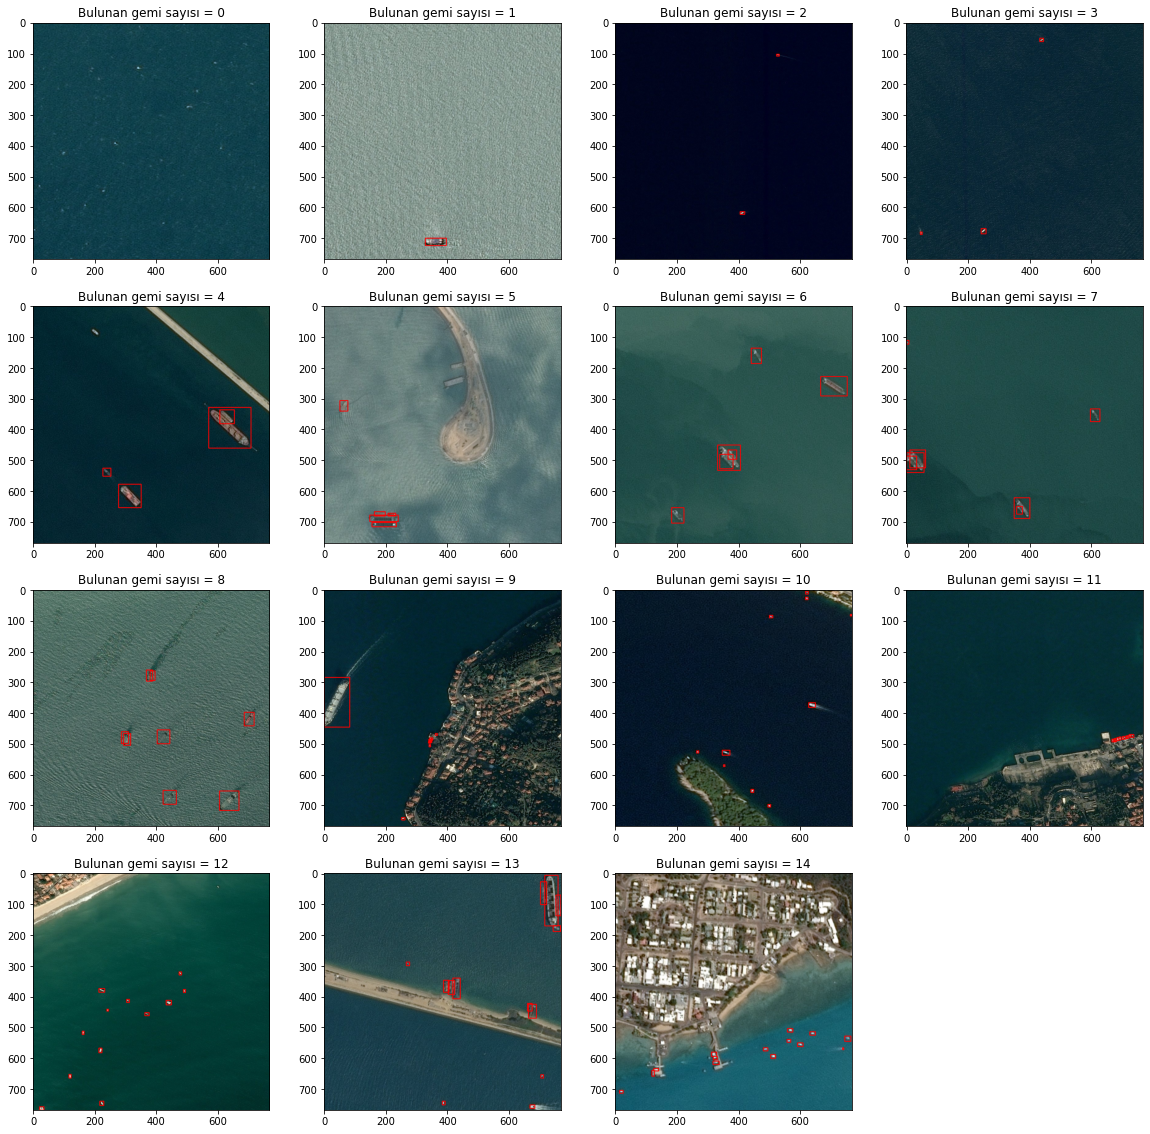

In [ ]:
#Visualizing bounding boxes and images
import PIL # We will import the packages at "use-time (just for this kernel)
plt.figure(figsize =(20,20))
for i in range(15):
    imageid = balanced_df[balanced_df.Ship ==i].iloc[0][0]
    image = np.array(cv2.imread(imageid)[:,:,::-1])
    if i>0:
        bbox = balanced_bbox[balanced_bbox.ImageId==imageid]["Boundingbox"]
        
        for items in bbox:
            Xmin  = int((items[0]-items[3]/2)*768)
            Ymin  = int((items[1]-items[2]/2)*768)
            Xmax  = int((items[0]+items[3]/2)*768)
            Ymax  = int((items[1]+items[2]/2)*768)
            cv2.rectangle(image,
                          (Xmin,Ymin),
                          (Xmax,Ymax),
                          (255,0,0),
                          thickness = 2)
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title("Bulunan gemi sayısı = {}".format(i))